In [78]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras_hub.src.layers.modeling.rotary_embedding import RotaryEmbedding
import json
import os
from typing import Dict, Tuple, List

In [79]:
from tqdm import tqdm

In [80]:
mixed_precision = True  # Enable mixed precision for significant speedup

if mixed_precision:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f'Mixed precision enabled: {policy}')

Mixed precision enabled: <DTypePolicy "mixed_float16">


In [81]:
# Set seeds for reproducibility
np.random.seed(999)
tf.random.set_seed(999)

# Constants for data processing
ESM_DIM = 1536  # Will be updated from metadata

# Constants
BLOSUM62 = {
    'A': [4, -1, -2, -2, 0, -1, -1, 0, -2, -1, -1, -1, -1, -2, -1, 1, 0, -3, -2, 0, -2, -1, 0],
    'R': [-1, 5, 0, -2, -3, 1, 0, -2, 0, -3, -2, 2, -1, -3, -2, -1, -1, -3, -2, -3, -1, 0, -1],
    'N': [-2, 0, 6, 1, -3, 0, 0, 0, 1, -3, -3, 0, -2, -3, -2, 1, 0, -4, -2, -3, 3, 0, -1],
    'D': [-2, -2, 1, 6, -3, 0, 2, -1, -1, -3, -4, -1, -3, -3, -1, 0, -1, -4, -3, -3, 4, 1, -1],
    'C': [0, -3, -3, -3, 9, -3, -4, -3, -3, -1, -1, -3, -1, -2, -3, -1, -1, -2, -2, -1, -3, -3, -2],
    'Q': [-1, 1, 0, 0, -3, 5, 2, -2, 0, -3, -2, 1, 0, -3, -1, 0, -1, -2, -1, -2, 0, 3, -1],
    'E': [-1, 0, 0, 2, -4, 2, 5, -2, 0, -3, -3, 1, -2, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1],
    'G': [0, -2, 0, -1, -3, -2, -2, 6, -2, -4, -4, -2, -3, -3, -2, 0, -2, -2, -3, -3, -1, -2, -1],
    'H': [-2, 0, 1, -1, -3, 0, 0, -2, 8, -3, -3, -1, -2, -1, -2, -1, -2, -2, 2, -3, 0, 0, -1],
    'I': [-1, -3, -3, -3, -1, -3, -3, -4, -3, 4, 2, -3, 1, 0, -3, -2, -1, -3, -1, 3, -3, -3, -1],
    'L': [-1, -2, -3, -4, -1, -2, -3, -4, -3, 2, 4, -2, 2, 0, -3, -2, -1, -2, -1, 1, -4, -3, -1],
    'K': [-1, 2, 0, -1, -3, 1, 1, -2, -1, -3, -2, 5, -1, -3, -1, 0, -1, -3, -2, -2, 0, 1, -1],
    'M': [-1, -1, -2, -3, -1, 0, -2, -3, -2, 1, 2, -1, 5, 0, -2, -1, -1, -1, -1, 1, -3, -1, -1],
    'F': [-2, -3, -3, -3, -2, -3, -3, -3, -1, 0, 0, -3, 0, 6, -4, -2, -2, 1, 3, -1, -3, -3, -1],
    'P': [-1, -2, -2, -1, -3, -1, -1, -2, -2, -3, -3, -1, -2, -4, 7, -1, -1, -4, -3, -2, -2, -1, -2],
    'S': [1, -1, 1, 0, -1, 0, 0, 0, -1, -2, -2, 0, -1, -2, -1, 4, 1, -3, -2, -2, 0, 0, 0],
    'T': [0, -1, 0, -1, -1, -1, -1, -2, -2, -1, -1, -1, -1, -2, -1, 1, 5, -2, -2, 0, -1, -1, 0],
    'W': [-3, -3, -4, -4, -2, -2, -3, -2, -2, -3, -2, -3, -1, 1, -4, -3, -2, 11, 2, -3, -4, -3, -2],
    'Y': [-2, -2, -2, -3, -2, -1, -2, -3, 2, -1, -1, -2, -1, 3, -3, -2, -2, 2, 7, -1, -3, -2, -1],
    'V': [0, -3, -3, -3, -1, -2, -2, -3, -3, 3, 1, -2, 1, -1, -2, -2, 0, -3, -1, 4, -3, -2, -1],
    'B': [-2, -1, 3, 4, -3, 0, 1, -1, 0, -3, -4, 0, -3, -3, -2, 0, -1, -4, -3, -3, 4, 1, -1],
    'Z': [-1, 0, 0, 1, -3, 3, 4, -2, 0, -3, -3, 1, -1, -3, -1, 0, -1, -3, -2, -2, 1, 4, -1],
    'X': [0, -1, -1, -1, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -2, 0, 0, -2, -1, -1, -1, -1, -1],
}

# Normalized
# BLOSUM62 = {
#  "A": [0.533, 0.2, 0.133, 0.133, 0.267, 0.2, 0.2, 0.267, 0.133, 0.2, 0.2, 0.2, 0.2, 0.133, 0.2, 0.333, 0.267, 0.067, 0.133, 0.267, 0.133, 0.2, 0.267],
#  "R": [0.2, 0.6, 0.267, 0.133, 0.067, 0.333, 0.267, 0.133, 0.267, 0.067, 0.133, 0.4, 0.2, 0.067, 0.133, 0.2, 0.2, 0.067, 0.133, 0.067, 0.2, 0.267, 0.2],
#  "N": [0.133, 0.267, 0.667, 0.333, 0.067, 0.267, 0.267, 0.267, 0.333, 0.067, 0.067, 0.267, 0.133, 0.067, 0.133, 0.333, 0.267, 0.0, 0.133, 0.067, 0.467, 0.267, 0.2],
#  "D": [0.133, 0.133, 0.333, 0.667, 0.067, 0.267, 0.4, 0.2, 0.2, 0.067, 0.0, 0.2, 0.067, 0.067, 0.2, 0.267, 0.2, 0.0, 0.067, 0.067, 0.533, 0.333, 0.2],
#  "C": [0.267, 0.067, 0.067, 0.067, 0.867, 0.067, 0.0, 0.067, 0.067, 0.2, 0.2, 0.067, 0.2, 0.133, 0.067, 0.2, 0.2, 0.133, 0.133, 0.2, 0.067, 0.067, 0.133],
#  "Q": [0.2, 0.333, 0.267, 0.267, 0.067, 0.6, 0.4, 0.133, 0.267, 0.067, 0.133, 0.333, 0.267, 0.067, 0.2, 0.267, 0.2, 0.133, 0.2, 0.133, 0.267, 0.467, 0.2],
#  "E": [0.2, 0.267, 0.267, 0.4, 0.0, 0.4, 0.6, 0.133, 0.267, 0.067, 0.067, 0.333, 0.133, 0.067, 0.2, 0.267, 0.2, 0.067, 0.133, 0.133, 0.333, 0.533, 0.2],
#  "G": [0.267, 0.133, 0.267, 0.2, 0.067, 0.133, 0.133, 0.667, 0.133, 0.0, 0.0, 0.133, 0.067, 0.067, 0.133, 0.267, 0.133, 0.133, 0.067, 0.067, 0.2, 0.133, 0.2],
#  "H": [0.133, 0.267, 0.333, 0.2, 0.067, 0.267, 0.267, 0.133, 0.8, 0.067, 0.067, 0.2, 0.133, 0.2, 0.133, 0.2, 0.133, 0.133, 0.4, 0.067, 0.267, 0.267, 0.2],
#  "I": [0.2, 0.067, 0.067, 0.067, 0.2, 0.067, 0.067, 0.0, 0.067, 0.533, 0.4, 0.067, 0.333, 0.267, 0.067, 0.133, 0.2, 0.067, 0.2, 0.467, 0.067, 0.067, 0.2],
#  "L": [0.2, 0.133, 0.067, 0.0, 0.2, 0.133, 0.067, 0.0, 0.067, 0.4, 0.533, 0.133, 0.4, 0.267, 0.067, 0.133, 0.2, 0.133, 0.2, 0.333, 0.0, 0.067, 0.2],
#  "K": [0.2, 0.4, 0.267, 0.2, 0.067, 0.333, 0.333, 0.133, 0.2, 0.067, 0.133, 0.6, 0.2, 0.067, 0.2, 0.267, 0.2, 0.067, 0.133, 0.133, 0.267, 0.333, 0.2],
#  "M": [0.2, 0.2, 0.133, 0.067, 0.2, 0.267, 0.133, 0.067, 0.133, 0.333, 0.4, 0.2, 0.6, 0.267, 0.133, 0.2, 0.2, 0.2, 0.2, 0.333, 0.067, 0.2, 0.2],
#  "F": [0.133, 0.067, 0.067, 0.067, 0.133, 0.067, 0.067, 0.067, 0.2, 0.267, 0.267, 0.067, 0.267, 0.667, 0.0, 0.133, 0.133, 0.333, 0.467, 0.2, 0.067, 0.067, 0.2],
#  "P": [0.2, 0.133, 0.133, 0.2, 0.067, 0.2, 0.2, 0.133, 0.133, 0.067, 0.067, 0.2, 0.133, 0.0, 0.733, 0.2, 0.2, 0.0, 0.067, 0.133, 0.133, 0.2, 0.133],
#  "S": [0.333, 0.2, 0.333, 0.267, 0.2, 0.267, 0.267, 0.267, 0.2, 0.133, 0.133, 0.267, 0.2, 0.133, 0.2, 0.533, 0.333, 0.067, 0.133, 0.133, 0.267, 0.267, 0.267],
#  "T": [0.267, 0.2, 0.267, 0.2, 0.2, 0.2, 0.2, 0.133, 0.133, 0.2, 0.2, 0.2, 0.2, 0.133, 0.2, 0.333, 0.6, 0.133, 0.133, 0.267, 0.2, 0.2, 0.267],
#  "W": [0.067, 0.067, 0.0, 0.0, 0.133, 0.133, 0.067, 0.133, 0.133, 0.067, 0.133, 0.067, 0.2, 0.333, 0.0, 0.067, 0.133, 1.0, 0.4, 0.067, 0.0, 0.067, 0.133],
#  "Y": [0.133, 0.133, 0.133, 0.067, 0.133, 0.2, 0.133, 0.067, 0.4, 0.2, 0.2, 0.133, 0.2, 0.467, 0.067, 0.133, 0.133, 0.4, 0.733, 0.2, 0.067, 0.133, 0.2],
#  "V": [0.267, 0.067, 0.067, 0.067, 0.2, 0.133, 0.133, 0.067, 0.067, 0.467, 0.333, 0.133, 0.333, 0.2, 0.133, 0.133, 0.267, 0.067, 0.2, 0.533, 0.067, 0.133, 0.2],
#  "B": [0.133, 0.2, 0.467, 0.533, 0.067, 0.267, 0.333, 0.2, 0.267, 0.067, 0.0, 0.267, 0.067, 0.067, 0.133, 0.267, 0.2, 0.0, 0.067, 0.067, 0.533, 0.333, 0.2],
#  "Z": [0.2, 0.267, 0.267, 0.333, 0.067, 0.467, 0.533, 0.133, 0.267, 0.067, 0.067, 0.333, 0.2, 0.067, 0.2, 0.267, 0.2, 0.067, 0.133, 0.133, 0.333, 0.533, 0.2],
#  "X": [0.267, 0.2, 0.2, 0.2, 0.133, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.133, 0.267, 0.267, 0.133, 0.2, 0.2, 0.2, 0.2, 0.2]
#
# }

# Create a reverse mapping from a BLOSUM62 vector to an amino acid character.
# The score lists are converted to tuples so they can be used as dictionary keys.
MASK_TOKEN = -1.0
NORM_TOKEN = 1.0
PAD_TOKEN = -2.0
PAD_VALUE = 0.0
MASK_VALUE = 0.0

AMINO_ACID_MAP = {tuple(v): k for k, v in BLOSUM62.items()}

AA = "ACDEFGHIKLMNPQRSTVWY"
AA_TO_INT = {a: i for i, a in enumerate(AA)}
PAD_INDEX_OHE = len(AA) # 20 total chars for OHE

# Create a mapping from Amino Acid to an integer index
AA_BLOSUM = "ARNDCQEGHILKMFPSTWYVBZX"
AA_TO_BLOSUM_IDX = {aa: i for i, aa in enumerate(AA_BLOSUM)}
PAD_INDEX_62 = len(AA_BLOSUM) # The new padding index is 23

# Create a constant TensorFlow tensor to act as a lookup table
BLOSUM62_VECTORS = np.array([BLOSUM62[aa] for aa in AA_BLOSUM] + [[0.0] * 23], dtype=np.float32)

def seq_to_onehot(sequence: str, max_seq_len: int) -> np.ndarray:
    """Convert peptide sequence to one-hot encoding"""
    arr = np.full((max_seq_len, 21), PAD_VALUE, dtype=np.float32) # initialize padding with 0
    for j, aa in enumerate(sequence.upper()[:max_seq_len]):
        arr[j, AA_TO_INT.get(aa, PAD_INDEX_OHE)] = 1.0
        # print number of UNKs in the sequence
    # num_unks = np.sum(arr[:, UNK_IDX_OHE])
    # zero out gaps
    arr[:, PAD_INDEX_OHE] = PAD_VALUE  # Set gaps to PAD_VALUE
    # if num_unks > 0:
    #     print(f"Warning: {num_unks} unknown amino acids in sequence '{sequence}'")
    return arr


def OHE_to_seq(ohe: np.ndarray, gap: bool = False) -> list:
    """
    Convert a one-hot encoded matrix back to a peptide sequence.
    # (B, max_pep_len, 21) -> (B, max_pep_len)
    Args:
        ohe: One-hot encoded matrix of shape (B, N, 21).
    Returns:
        sequence: Peptide sequence as a string. (B,)
    """
    sequence = []
    for i in range(ohe.shape[0]):  # Iterate over batch dimension
        seq = []
        for j in range(ohe.shape[1]):  # Iterate over sequence length
            if gap and np.all(ohe[i, j] == 0):
                seq.append('-')
            else:
                aa_index = np.argmax(ohe[i, j])  # Get index of the max value in one-hot encoding
                if aa_index < len(AA):  # Check if it's a valid amino acid index
                    seq.append(AA[aa_index])
                else:
                    seq.append('-')  # Use '-' for unknown amino acids
        sequence.append(''.join(seq))  # Join the list into a string
    return sequence  # Return list of sequences


def OHE_to_seq_single(ohe: np.ndarray, gap=False) -> str:
    """
    Convert a one-hot encoded matrix back to a peptide sequence.
    Args:
        ohe: One-hot encoded matrix of shape (N, 21).
    Returns:
        sequence: Peptide sequence as a string.
    """
    seq = []
    for j in range(ohe.shape[0]):  # Iterate over sequence length
        if gap and np.all(ohe[j] == 0):
            seq.append('-')
        else:
            aa_index = np.argmax(ohe[j])  # Get index of the max value in one-hot encoding
            seq.append(AA[aa_index])
    return ''.join(seq)  # Join the list into a string

def seq_to_blossom62(sequence: str, max_seq_len: int) -> np.ndarray:
    """
    Converts a peptide sequence into a matrix using BLOSUM62 substitution scores.
    This function maps each amino acid in the input sequence to its corresponding
    vector of substitution scores from the BLOSUM62 matrix. The resulting matrix
    is padded or truncated to a specified maximum length.
    Args:
        sequence (str): The input peptide sequence.
        max_seq_len (int): The target length for the output matrix. Sequences
                           shorter than this will be padded with zeros, and
                           longer ones will be truncated.
    Returns:
        np.ndarray: A NumPy array of shape (max_seq_len, 23) where each row
                    corresponds to an amino acid's BLOSUM62 scores.
    """
    # The BLOSUM62 matrix has 23 columns corresponding to the score list length.
    num_features = 23
    # Initialize the output array with the padding value (0.0).
    arr = np.full((max_seq_len, num_features), PAD_VALUE, dtype=np.float32)
    # Use the vector for '-' (unknown) as the default for any character
    # not found in the BLOSUM62 dictionary, including gaps ('-').
    default_vector = BLOSUM62['X']
    # Iterate over the sequence up to the maximum length.
    for i, aa in enumerate(sequence.upper()[:max_seq_len]):
        # Retrieve the BLOSUM62 vector for the current amino acid.
        # If the amino acid is not a key in the dictionary, use the default vector.
        blosum_vector = BLOSUM62.get(aa, default_vector)
        arr[i, :] = blosum_vector
    return arr


def blosum62_to_seq(blosum_matrix: np.ndarray) -> str:
    """
    Converts a BLOSUM62 matrix back into a peptide sequence.
    This function iterates through each row of the input matrix, finds the
    corresponding amino acid from the BLOSUM62 mapping, and reconstructs the
    sequence. It stops when it encounters a padding row (all zeros).
    Args:
        blosum_matrix (np.ndarray): A NumPy array of shape (N, 23) containing
                                    BLOSUM62 scores.
    Returns:
        str: The reconstructed peptide sequence.
    """
    sequence = []
    # Iterate through each row (vector) in the input matrix.
    for row in blosum_matrix:
        # Check if the row is a padding vector (all elements are PAD_VALUE).
        # If so, we have reached the end of the sequence.
        if not np.any(row):
            break
        # Convert the NumPy array row to a tuple to make it hashable.
        row_tuple = tuple(np.array(row))
        # Look up the amino acid in the reverse map. Default to '-' if not found.
        amino_acid = AMINO_ACID_MAP.get(row_tuple, '-')
        sequence.append(amino_acid)
    return "".join(sequence)


def seq_to_indices_blosum62(seq, max_seq_len):
    """Correctly converts an amino acid sequence to an array of integer indices."""
    indices = np.full(max_seq_len, PAD_INDEX_62, dtype=np.int64)
    for i, aa in enumerate(seq.upper()[:max_seq_len]):
        # Use the correct mapping: character -> index
        indices[i] = AA_TO_BLOSUM_IDX.get(aa, PAD_INDEX_62)
    return indices


def seq_to_ohe_indices(seq, max_seq_len):
    """Converts an amino acid sequence to an array of integer indices FOR OHE TARGET."""
    indices = np.full(max_seq_len, PAD_INDEX_OHE, dtype=np.int64)
    for i, aa in enumerate(seq.upper()[:max_seq_len]):
        indices[i] = AA_TO_INT.get(aa, PAD_INDEX_OHE)
    return indices


def get_embed_key(key: str, emb_dict: Dict[str, str]) -> str:  # why ndarray?
    """
    Get the embedding key for a given allele key.
    If the key is not found in the embedding dictionary, return None.
    # find the matching emb key in the emb_dict.
    Sometimes the emb key is longer than the allele key, so we need to check if the key is a substring of the emb key.
    """
    # Use a generator expression for efficient lookup
    return next((emb_key for emb_key in emb_dict if emb_key.upper().startswith(key.upper())), None)


def get_seq(key: str, seq_dict: Dict[str, str]) -> str:
    """
    Get the sequence for a given allele key.
    If the key is not found in the sequence dictionary, return None.
    """
    return next((seq for seq_key, seq in seq_dict.items() if seq_key.upper().startswith(key.upper())), None)


def clean_key(allele_key: str) -> str:
    """
    Clean allele keys by removing special characters and converting to uppercase.
    This is useful for matching keys in embedding dictionaries.
    """
    if allele_key is None:
        return "None"
    mapping = str.maketrans({'*': '', ':': '', ' ': '', '/': '_'})
    return allele_key.translate(mapping).upper()


def get_mhc_seq_class2(key, embed_map, seq_map):
    # print(f"Processing key: {key}")  # Debugging line
    if key is None: return ''
    key_parts = key.split('_')
    # print(f"Key parts: {key_parts}")  # Debugging line
    if len(key_parts) >= 2:
        key1 = get_embed_key(key_parts[0], embed_map)
        key2 = get_embed_key(key_parts[1], embed_map)
        if embed_map.get(key1, None) is None or embed_map.get(key2, None) is None:
            print(
                f"Warning: Embedding not found for embd_key 1: '{key1}' 2: '{key2}' in input:'{key_parts[0]}', '{key_parts[1]}'")
        # print(f"Key1: {key1}, Key2: {key2}")  # Debugging line
        seq1 = get_seq(key_parts[0], seq_map) if key1 else ''
        seq2 = get_seq(key_parts[1], seq_map) if key2 else ''
        # print(f"Seq1: {seq1}, Seq2: {seq2}")  # Debugging line
        return seq1 + seq2
    else:
        raise ValueError(f"Unexpected MHC class II key format: '{key}'")


def get_embed_key_class2(key, embed_map):
    if key is None: return None
    key_parts = key.split('_')
    if len(key_parts) >= 2:
        key1 = get_embed_key(key_parts[0], embed_map)
        key2 = get_embed_key(key_parts[1], embed_map)
        if embed_map.get(key1, None) is None or embed_map.get(key2, None) is None:
            print(
                f"Warning: Embedding not found for embd_key 1: '{key1}' 2: '{key2}' in input:'{key_parts[0]}', '{key_parts[1]}'")
        return "_".join(filter(None, [key1, key2]))
    else:
        raise ValueError(f"Unexpected MHC class II key format: '{key}'")


@tf.function
def _neg_inf(dtype: tf.dtypes.DType) -> tf.Tensor:
    """Return a large negative constant suited for masking in given dtype."""
    if dtype == tf.float16 or dtype == tf.bfloat16:
        return tf.constant(-1e4, dtype=dtype)
    return tf.constant(-1e9, dtype=dtype)


# Custom layers from your original code
@tf.keras.utils.register_keras_serializable(package='Custom', name='AsymmetricPenaltyBinaryCrossentropy')
class AsymmetricPenaltyBinaryCrossentropy(tf.keras.losses.Loss):
    """Asymmetric Penalty Binary Cross-Entropy Loss"""

    def __init__(self, label_smoothing=0.1, asymmetry_strength_pos=5.0, asymmetry_strength_neg=0.5,
                 name='asymmetric_penalty_binary_crossentropy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.label_smoothing = label_smoothing
        self.asymmetry_strength_pos = asymmetry_strength_pos
        self.asymmetry_strength_neg = asymmetry_strength_neg


    def call(self, y_true, y_pred):
        """
        Asymmetric Penalty Binary Cross-Entropy Loss

        Features:
        - Minimum at smoothed label: p = 1-ε (true=1), p = ε (true=0)
        - Steeper penalty toward opposing class
        - Gentler penalty toward actual class

        Args:
            y_true: Ground truth binary labels
            y_pred: Predicted probabilities
            label_smoothing: Smoothing parameter ε (0.05-0.15 recommended)
            asymmetry_strength: Controls penalty asymmetry (0.3-0.8 recommended)
        """
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)

        # Base with label smoothing
        y_smooth = y_true * (1 - self.label_smoothing) + (1 - y_true) * self.label_smoothing
        base_loss = -(y_smooth * tf.math.log(y_pred) + (1 - y_smooth) * tf.math.log(1 - y_pred))

        # Optimal prediction points
        optimal = y_true * (1 - self.label_smoothing) + (1 - y_true) * self.label_smoothing
        base_loss_optimal = -(y_smooth * tf.math.log(optimal) + (1 - y_smooth) * tf.math.log(1 - optimal))

        # Normalize so min = 0
        base_loss = base_loss - base_loss_optimal

        # Distance from optimal points
        optimal_true1 = 1 - self.label_smoothing
        optimal_true0 = self.label_smoothing
        dist_from_optimal_true1 = tf.abs(y_pred - optimal_true1)
        dist_from_optimal_true0 = tf.abs(y_pred - optimal_true0)

        # Asymmetric penalties with separate strengths
        penalty_true1 = y_true * tf.where(
            y_pred < optimal_true1,
            self.asymmetry_strength_pos * dist_from_optimal_true1**2,
            self.asymmetry_strength_pos * 0.3 * dist_from_optimal_true1**2
        )

        penalty_true0 = (1 - y_true) * tf.where(
            y_pred > optimal_true0,
            self.asymmetry_strength_neg * dist_from_optimal_true0**2,
            self.asymmetry_strength_neg * 0.3 * dist_from_optimal_true0**2
        )

        total_loss = tf.reduce_mean(base_loss + penalty_true1 + penalty_true0)
        return tf.maximum(0.0, total_loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            'label_smoothing': self.label_smoothing,
            'asymmetry_strength_pos': self.asymmetry_strength_pos,
            'asymmetry_strength_neg': self.asymmetry_strength_neg
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='SelfAttentionWith2DMask')
class SelfAttentionWith2DMask(keras.layers.Layer):
    """
    Custom self-attention layer that supports 2D masks.
    """

    def __init__(self, query_dim, context_dim, output_dim, heads=4,
                 return_att_weights=False, name='SelfAttentionWith2DMask',
                 epsilon=1e-6, mask_token=-1., pad_token=-2., self_attn_mhc=True, apply_rope=True):
        super().__init__(name=name)
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.heads = heads
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads  # Attention dimension per head
        self.self_attn_mhc = self_attn_mhc
        self.apply_rope = apply_rope  # flag for rotary positional embedding

    def build(self, input_shape):
        # Validate input dim matches provided dims (since a single x is used for q/k/v)
        in_dim = int(input_shape[-1])
        if in_dim != self.query_dim or in_dim != self.context_dim:
            raise ValueError(
                f"Input dim {in_dim} must match query_dim {self.query_dim} and context_dim {self.context_dim}.")

        # Projection weights
        self.norm1 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln1_{self.name}')
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        self.g_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_uniform', trainable=True, name=f'g_proj_{self.name}')
        self.norm2 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln2_{self.name}')

        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.keras.mixed_precision.global_policy().compute_dtype))

        if self.apply_rope:
            if (self.att_dim % 2) != 0:
                raise ValueError(f"RotaryEmbedding requires even att_dim, got {self.att_dim}.")
            # q/k have shape (B, H, S, D): sequence_axis=2, feature_axis=-1
            self.rope = RotaryEmbedding(sequence_axis=2, feature_axis=-1, name=f'rope_{self.name}')

        super().build(input_shape)

    @tf.function(reduce_retracing=True)
    def call(self, x_pmhc, p_mask, m_mask):
        """
        Args:
            x: Tensor of shape (B, N+M, query_dim) for query.
            p_mask: Tensor of shape (B, N) for peptide mask.
            m_mask: Tensor of shape (B, M) for mhc mask.
        Returns:
            Tensor of shape (B, N+M, output_dim)
        """
        x_pmhc = self.norm1(x_pmhc)  # Normalize input
        p_mask = tf.cast(p_mask, self.compute_dtype)
        m_mask = tf.cast(m_mask, self.compute_dtype)
        p_mask = tf.where(p_mask == self.pad_token, x=0., y=1.)  # (B, N)
        m_mask = tf.where(m_mask == self.pad_token, x=0., y=1.)  # (B, M)

        q = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc , self.compute_dtype), tf.cast(self.q_proj, self.compute_dtype))  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        k = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.k_proj, self.compute_dtype))  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        v = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.v_proj, self.compute_dtype))  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        g = tf.einsum('bxd,hde->bhxe', tf.cast(x_pmhc, self.compute_dtype), tf.cast(self.g_proj, self.compute_dtype))  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)

        if self.apply_rope:
            q = self.rope(q)
            k = self.rope(k)

        att = tf.einsum('bhxe,bhye->bhxy', q, k) * tf.cast(self.scale, self.compute_dtype)  # (B, H, N+M, D) * (B, H, D, N+M) -> (B, H, N+M, N+M)
        # Create 2D mask
        mask_2d = self.mask_2d(p_mask, m_mask)
        mask_2d = tf.cast(mask_2d, self.compute_dtype)  # (B, N+M, N+M)
        mask_2d_neg = (1.0 - mask_2d) * _neg_inf(att.dtype)  # Apply mask to attention scores
        att = tf.nn.softmax(att + tf.expand_dims(mask_2d_neg, axis=1), axis=-1)  # Apply softmax to attention scores
        att *= tf.expand_dims(mask_2d,
                              axis=1)  # remove the impact of row wise attention of padded tokens. since all are 1e-9
        out = tf.matmul(att, v)  # (B, H, N+M, N+M) * (B, H, N+M, D) -> (B, H, N+M, D)
        out *= tf.nn.sigmoid(g)  # Apply gating mechanism
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x_pmhc)[0], tf.shape(x_pmhc)[1], self.heads * self.att_dim])
        out = tf.matmul(out, tf.cast(self.out_w, self.compute_dtype)) + tf.cast(self.out_b, self.compute_dtype)
        out = self.norm2(out)
        if self.return_att_weights:
            return out, att
        else:
            return out

    def mask_2d(self, p_mask, m_mask):
        p_mask = tf.cast(p_mask, self.compute_dtype)
        m_mask = tf.cast(m_mask, self.compute_dtype)
        p_mask = tf.expand_dims(p_mask, axis=-1)
        m_mask = tf.expand_dims(m_mask, axis=-1)  # (B, N, 1), (B, M, 1)
        # zero square masks
        self_peptide_mask = tf.zeros_like(p_mask, dtype=self.compute_dtype)  # (B, N, 1)
        self_peptide_mask_2d = tf.broadcast_to(self_peptide_mask, (
            tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(p_mask)[1]))  # (B, N, N)
        if self.self_attn_mhc:
            self_mhc_mask = m_mask
        else:
            self_mhc_mask = tf.zeros_like(m_mask, dtype=self.compute_dtype)
        self_mhc_mask_2d = tf.broadcast_to(self_mhc_mask, (
            tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(m_mask)[1]))  # (B, M, M)
        # one and zero masks
        pep_mhc_mask_secondpart = tf.broadcast_to(p_mask, (tf.shape(p_mask)[0], tf.shape(p_mask)[1],
                                                           tf.shape(m_mask)[-1]))  # (B, N, M)
        pep_mhc_mask_secondpart = pep_mhc_mask_secondpart * tf.transpose(m_mask,
                                                                         perm=[0, 2, 1])  # (B,N,M)*(B,1,M)=(B, N, M)
        mhc_pep_mask_secondpart = tf.broadcast_to(m_mask, (tf.shape(m_mask)[0], tf.shape(m_mask)[1],
                                                           tf.shape(p_mask)[-1]))  # (B, M, N)
        mhc_pep_mask_secondpart = mhc_pep_mask_secondpart * tf.transpose(p_mask,
                                                                         perm=[0, 2, 1])  # (B,M,N)*(B,1,N)=(B, M, N)
        # combined masks (B,N+M,N+M)
        combined_mask_1 = tf.concat([self_peptide_mask_2d, pep_mhc_mask_secondpart], axis=2)  # (B, N, N+M)
        combined_mask_2 = tf.concat([mhc_pep_mask_secondpart, self_mhc_mask_2d], axis=2)  # (B, M, N+M)
        final_mask = tf.concat([combined_mask_1, combined_mask_2], axis=1)  # (B, N+M, N+M)
        final_mask_t = tf.transpose(final_mask, perm=[0, 2, 1])  # (B,... same)
        final_mask = tf.multiply(final_mask, final_mask_t)
        return final_mask


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='AddGaussianNoise')
class AddGaussianNoise(layers.Layer):
    def __init__(self, std=0.1, **kw):
        super().__init__(**kw)
        self.std = std

    def call(self, x, training=None):
        if training:
            noise = tf.random.normal(tf.shape(x), stddev=tf.cast(self.std, x.dtype), dtype=x.dtype)
            return x + noise
        return x


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='PositionalEncoding')
class PositionalEncoding(keras.layers.Layer):
    """Sinusoidal Positional Encoding layer that applies encodings only to non-masked tokens."""

    def __init__(self, embed_dim, pos_range=100, mask_token=-1., pad_token=-2., name='positional_encoding', **kwargs):
        super().__init__(name=name)
        self.embed_dim = embed_dim
        self.pos_range = pos_range
        self.mask_token = mask_token
        self.pad_token = pad_token

    def build(self, x):
        pos = tf.range(self.pos_range, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(self.embed_dim, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = tf.pow(300.0, -(2.0 * tf.floor(i // 2)) / tf.cast(self.embed_dim, tf.float32))
        angle_rads = pos * angle_rates

        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        self.pos_encoding = tf.cast(pos_encoding, dtype=self.compute_dtype)

    def call(self, x, mask):
        seq_len = tf.shape(x)[1]
        pe = self.pos_encoding[:, :seq_len, :]
        mask = tf.cast(mask[:, :, tf.newaxis], x.dtype)
        mask = tf.where(mask == self.pad_token, tf.cast(0.0, x.dtype), tf.cast(1.0, x.dtype))
        pe = tf.cast(pe, x.dtype) * mask
        return x + pe


@tf.keras.utils.register_keras_serializable(package='Custom', name='GlobalMeanPooling1D')
class GlobalMeanPooling1D(layers.Layer):
    """Global mean pooling layer."""

    def __init__(self, axis=-1, name="global_mean_pooling_", **kwargs):
        super(GlobalMeanPooling1D, self).__init__(name=name)
        self.axis = axis

    def call(self, input_tensor):
        return tf.math.reduce_mean(input_tensor, axis=self.axis, keepdims=False)


@tf.keras.utils.register_keras_serializable(package='Custom', name='GlobalSTDPooling1D')
class GlobalSTDPooling1D(layers.Layer):
    """Global Standard Deviation Pooling layer."""

    def __init__(self, axis=1, name='global_std_pooling', **kwargs):
        super(GlobalSTDPooling1D, self).__init__(name=name)
        self.axis = axis

    def call(self, input_tensor):
        pooled_std = tf.math.reduce_std(input_tensor, axis=self.axis, keepdims=False, name=None)
        return pooled_std + 1e-9


@tf.keras.utils.register_keras_serializable(package='Custom', name='GlobalMaxPooling1D')
class GlobalMaxPooling1D(layers.Layer):
    """Global max pooling layer."""

    def __init__(self, axis=-1, name="global_max_pooling_", **kwargs):
        super(GlobalMaxPooling1D, self).__init__(name=name)
        self.axis = axis

    def call(self, input_tensor):
        return tf.math.reduce_max(input_tensor, axis=self.axis, keepdims=False)


@tf.keras.utils.register_keras_serializable(package='custom_layers', name='MaskedEmbedding')
class MaskedEmbedding(keras.layers.Layer):
    def __init__(self, mask_token=-1., pad_token=-2., name='masked_embedding', **kwargs):
        super().__init__(name=name)
        self.mask_token = mask_token
        self.pad_token = pad_token

    def call(self, x, mask):
        mask = tf.cast(mask, tf.float32)
        mask = tf.where((mask == self.pad_token) | (mask == self.mask_token), 0., 1.)
        mask = tf.cast(mask, x.dtype)
        return x * mask[:, :, tf.newaxis]

    def get_config(self):
        config = super().get_config()
        config.update({
            'mask_token': self.mask_token,
            'pad_token': self.pad_token,
        })
        return config


@tf.function(reduce_retracing=True)
def masked_categorical_crossentropy(y_true_and_pred, mask, pad_token=-2.0, sample_weight=None, type='cce'):
    """Compute masked categorical cross-entropy loss."""
    y_true, y_pred = tf.split(y_true_and_pred, num_or_size_splits=2, axis=-1)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.0)

    mask = tf.cast(tf.not_equal(mask, pad_token), tf.float32)
    if mask.shape.rank is not None and mask.shape.rank > 2 and mask.shape[-1] == 1:
        mask = tf.squeeze(mask, axis=-1)

    if type == 'cce':
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    elif type == 'mse':
        loss = tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
    else:
        raise ValueError(f"Unsupported loss type: {type}")

    mask = tf.cast(tf.broadcast_to(mask, tf.shape(loss)), tf.float32)
    masked_loss = loss * mask

    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, tf.float32)
        if sample_weight.shape.rank == 2 and sample_weight.shape[1] == 1:
            sample_weight = tf.squeeze(sample_weight, axis=-1)
        masked_loss *= sample_weight[:, tf.newaxis]
        mask *= sample_weight[:, tf.newaxis]

    total_loss = tf.reduce_sum(masked_loss)
    total_weight = tf.reduce_sum(mask)
    ce_loss = tf.math.divide_no_nan(total_loss, total_weight)
    return tf.cast(ce_loss, tf.float32)

@tf.keras.utils.register_keras_serializable(package='Custom', name='BinaryMCC')
class BinaryMCC(tf.keras.metrics.Metric):
    """
    Matthews Correlation Coefficient for binary classification.

    Simple implementation using the direct formula:
    MCC = (TP*TN - FP*FN) / sqrt((TP+FP)(TP+FN)(TN+FP)(TN+FN))

    Range: -1 (worst) to +1 (perfect), 0 = random
    """

    def __init__(self, name='binary_mcc', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    @tf.function(reduce_retracing=True)
    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert to binary
        y_pred_binary = tf.cast(y_pred >= self.threshold, tf.float32)
        y_true_binary = tf.cast(y_true, tf.float32)

        # Calculate TP, TN, FP, FN
        tp = tf.reduce_sum(y_true_binary * y_pred_binary)
        tn = tf.reduce_sum((1 - y_true_binary) * (1 - y_pred_binary))
        fp = tf.reduce_sum((1 - y_true_binary) * y_pred_binary)
        fn = tf.reduce_sum(y_true_binary * (1 - y_pred_binary))

        # Update running totals
        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    @tf.function(reduce_retracing=True)
    def result(self):
        # MCC = (TP*TN - FP*FN) / sqrt((TP+FP)(TP+FN)(TN+FP)(TN+FN))
        numerator = self.tp * self.tn - self.fp * self.fn
        denominator = tf.sqrt(
            (self.tp + self.fp) * (self.tp + self.fn) *
            (self.tn + self.fp) * (self.tn + self.fn)
        )

        # Handle division by zero
        return tf.where(
            tf.equal(denominator, 0.0),
            tf.constant(0.0, dtype=self.dtype),
            numerator / denominator
        )

    def reset_state(self):
        self.tp.assign(0.0)
        self.tn.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

In [82]:
# original

def pmbind_multitask_modified(max_pep_len: int,
                              max_mhc_len: int,
                              emb_dim: int = 32,
                              heads: int = 2,
                              transformer_layers: int = 2,
                              mask_token: float = MASK_TOKEN,
                              pad_token: float = PAD_TOKEN,
                              noise_std: float = 0.1,
                              latent_dim: int = 128,
                              drop_out_rate: float = 0.2,
                              l2_reg: float = 0.01,
                              ESM_dim: int = 1536):
    """
    A multi-task model for semi-supervised pMHC analysis, updated to use
    the custom SelfAttentionWith2DMask layer.
    """
    # -------------------------------------------------------------------
    # INPUTS
    # -------------------------------------------------------------------
    pep_blossom62_in = layers.Input((max_pep_len, 23), name="pep_blossom62")
    pep_mask_in = layers.Input((max_pep_len,), name="pep_mask")
    pep_ohe_target_in = layers.Input((max_pep_len, 21), name="pep_ohe_target")

    mhc_emb_in = layers.Input((max_mhc_len, ESM_dim), name="mhc_emb")
    mhc_mask_in = layers.Input((max_mhc_len,), name="mhc_mask")
    mhc_ohe_target_in = layers.Input((max_mhc_len, 21), name="mhc_ohe_target")

    # -------------------------------------------------------------------
    # SHARED ENCODER
    # -------------------------------------------------------------------
    # 1. Embed Peptide and MHC to the same dimension
    pep = MaskedEmbedding(mask_token, pad_token, name="pep_mask_embed")(pep_blossom62_in, pep_mask_in)
    # pep = layers.LayerNormalization(name="pep_norm_input1")(pep)
    pep = PositionalEncoding(23, int(max_pep_len * 3), name="pep_pos_enc")(pep, pep_mask_in)
    pep = layers.GaussianNoise(noise_std, name="pep_gaussian_noise")(pep)
    pep = layers.SpatialDropout1D(drop_out_rate, name="pep_dropout")(
        pep)  # SpatialDropout1D for sequence data to drop entire feature maps
    pep = layers.Dense(emb_dim, name="pep_dense_embed")(pep)
    pep = layers.Dropout(drop_out_rate)(pep)

    mhc = MaskedEmbedding(mask_token, pad_token, name="mhc_mask_embed")(mhc_emb_in, mhc_mask_in)
    # mhc = layers.LayerNormalization(name="mhc_norm_layer_inp")(mhc)
    mhc = layers.GaussianNoise(noise_std, name="mhc_gaussian_noise")(mhc)
    mhc = PositionalEncoding(ESM_dim, int(max_mhc_len * 3), name="mhc_pos_enc")(mhc, mhc_mask_in)
    mhc = layers.SpatialDropout1D(drop_out_rate, name="mhc_dropout")(
        mhc)  # SpatialDropout1D for sequence data to drop entire feature maps
    mhc = layers.Dense(emb_dim, name="mhc_dense_embed")(mhc)
    mhc = layers.Dropout(drop_out_rate)(mhc)
    #mhc = layers.LayerNormalization(name="mhc_layer_norm")(mhc)

    pmhc_concat = layers.Concatenate(axis=1, name="pmhc_concat")([pep, mhc])  # (B, P+M, D)

    # pmhc self-attention with 2D mask
    pmhc_interaction, pmhc_attn_weights = SelfAttentionWith2DMask(
        query_dim=emb_dim,
        context_dim=emb_dim,
        output_dim=emb_dim,
        heads=heads,
        return_att_weights=True,
        self_attn_mhc=False,  # Prevent both peptide and MHC self-attention in this layer
        apply_rope=True,
        name="pmhc_2d_masked_attention"
    )(pmhc_concat, pep_mask_in, mhc_mask_in)

    # The final output of the encoder is our shared latent sequence
    latent_sequence = pmhc_interaction  # Shape: (B, P+M, D)
    #latent_sequence = layers.BatchNormalization(name="latent_sequence_norm")(latent_sequence)

    # -------------------------------------------------------------------
    # TASK 1: BINDING PREDICTION HEAD # TODO this part directly affects clustering
    # -------------------------------------------------------------------
    # pooled_latent = GlobalMaxPooling1D(name="latent_vector_pool-2", axis=-2)(latent_sequence) # (B, D) # Tells how strong the overall signal is across the sequence (using this forces the model to pu one feature as the distance/binder information)
    pooled_std2 = GlobalSTDPooling1D(name="latent_vector_std-2", axis=-2)(
       latent_sequence)  # (B, D) # Tells how much variation there is in the signal across the sequence
    pooled_mean1 = GlobalMeanPooling1D(name="latent_vector_pool-1", axis=-1)(
       latent_sequence)  # (B, P+M) # Tells how strong the overall signal is across the features
    # pooled_std1 = GlobalSTDPooling1D(name="latent_vector_std-1", axis=-1)(latent_sequence)  # (B, P+M) # Tells how much variation there is in the signal across the features

    # concatenate mean and std pooled vectors
    pooled_latent = layers.Concatenate(name="pooled_latent_concat", axis=-1)(
       [pooled_mean1, pooled_std2])  # (B, 1*(D+P+M))

    binding_head = layers.Dropout(drop_out_rate * 1.5, name='dropout_pooled_latent')(pooled_latent)
    binding_head = layers.Dense(emb_dim // 2, activation="gelu", name="binding_dense1",
                                kernel_regularizer=keras.regularizers.l2(l2_reg),
                                bias_regularizer=keras.regularizers.l2(l2_reg))(binding_head)
    binding_head = layers.Dropout(drop_out_rate, name="binding_dropout2")(binding_head)
    binding_pred = layers.Dense(1, activation="sigmoid", name="binding_pred", dtype="float32")(binding_head)  # (B, 1)

    # -------------------------------------------------------------------
    # TASK 2: RECONSTRUCTION HEAD
    # -------------------------------------------------------------------
    pep_latent_seq = latent_sequence[:, :max_pep_len, :]  # (B, P, D)
    mhc_latent_seq = latent_sequence[:, max_pep_len:, :]  # (B, M, D)

    pep_recon_head = layers.Dropout(drop_out_rate, name='pep_recon_dropout_1')(pep_latent_seq)
    pep_recon_head = layers.Dense(emb_dim * 2, activation='relu')(pep_recon_head)
    pep_recon_head = layers.Dropout(drop_out_rate, name='pep_recon_dropout_2')(pep_recon_head)
    pep_recon_pred = layers.Dense(21, activation='softmax', name='pep_reconstruction_pred')(pep_recon_head)

    mhc_recon_head = layers.Dropout(drop_out_rate, name='mhc_recon_dropout_1')(mhc_latent_seq)
    mhc_recon_head = layers.Dense(emb_dim * 2, activation='relu')(mhc_recon_head)
    mhc_recon_head = layers.Dropout(drop_out_rate, name='mhc_recon_dropout_2')(mhc_recon_head)
    mhc_recon_pred = layers.Dense(21, activation='softmax', name='mhc_reconstruction_pred')(mhc_recon_head)

    pep_out = layers.Concatenate(name='pep_ytrue_ypred')([pep_ohe_target_in, pep_recon_pred])
    mhc_out = layers.Concatenate(name='mhc_ytrue_ypred')([mhc_ohe_target_in, mhc_recon_pred])

    # -------------------------------------------------------------------
    # MODEL DEFINITION
    # -------------------------------------------------------------------
    pMHC_multitask_model = keras.Model(
        inputs=[pep_blossom62_in, pep_mask_in, mhc_emb_in, mhc_mask_in, pep_ohe_target_in, mhc_ohe_target_in],
        outputs={
            "pep_ytrue_ypred": pep_out,
            "mhc_ytrue_ypred": mhc_out,
            "cls_ypred": binding_pred,
            "attn_weights": pmhc_attn_weights,  # (B, heads, P+M, P+M)
            "latent_vector": pooled_latent,  # (B, P+M+D)
            "latent_seq": latent_sequence  # (B, P+M, D)
        },
        name="pMHC_Multitask_Transformer_Custom_Attention"
    )

    return pMHC_multitask_model


In [83]:
# ============================================================================
# PARQUET DATA LOADING WITH DATAGENERATOR AND DYNAMIC MASKING
# ============================================================================


# Global variables for DataGenerator
EMB_DB_p: np.lib.npyio.NpzFile | None = None
MHC_CLASS = 1


def load_embedding_db(npz_path: str):
    """Load embedding database with memory mapping."""
    try:
        # Try loading without explicit allow_pickle (defaults to True)
        return np.load(npz_path, mmap_mode="r")
    except ValueError as e:
        if "allow_pickle" in str(e):
            # If pickle error, try with explicit allow_pickle=True
            print(f"Warning: NPZ file contains pickled data, loading with allow_pickle=True")
            return np.load(npz_path, mmap_mode="r", allow_pickle=True)
        else:
            raise e



def apply_dynamic_masking(features, emd_mask_d2=True):
    """
    Applies random masking for training augmentation inside the tf.data pipeline.
    This version is corrected to match the original DataGenerator logic.
    """
    # Peptide Masking
    valid_pep_positions = tf.where(tf.equal(features["pep_mask"], NORM_TOKEN))
    num_valid_pep = tf.shape(valid_pep_positions)[0]
    # At least 2 positions, or 15% of the valid sequence length
    num_to_mask_pep = tf.maximum(2, tf.cast(tf.cast(num_valid_pep, tf.float32) * 0.15, tf.int32))
    shuffled_pep_indices = tf.random.shuffle(valid_pep_positions)[:num_to_mask_pep]
    if tf.shape(shuffled_pep_indices)[0] > 0:
        # Update the mask to MASK_TOKEN (-1.0)
        features["pep_mask"] = tf.tensor_scatter_nd_update(features["pep_mask"], shuffled_pep_indices,
                                                           tf.repeat(MASK_TOKEN, num_to_mask_pep))
        # Zero out the feature values for the masked positions
        feat_dtype = features["pep_blossom62"].dtype
        mask_updates_pep = tf.fill([num_to_mask_pep, tf.shape(features["pep_blossom62"])[-1]],
                                   tf.cast(MASK_VALUE, feat_dtype))
        features["pep_blossom62"] = tf.tensor_scatter_nd_update(features["pep_blossom62"], shuffled_pep_indices,
                                                                mask_updates_pep)
    # MHC Masking
    valid_mhc_positions = tf.where(tf.equal(features["mhc_mask"], NORM_TOKEN))
    num_valid_mhc = tf.shape(valid_mhc_positions)[0]
    # At least 5 positions, or 15% of the valid sequence length
    num_to_mask_mhc = tf.maximum(10, tf.cast(tf.cast(num_valid_mhc, tf.float32) * 0.15, tf.int32))
    shuffled_mhc_indices = tf.random.shuffle(valid_mhc_positions)[:num_to_mask_mhc]
    if tf.shape(shuffled_mhc_indices)[0] > 0:
        # Update the mask to MASK_TOKEN (-1.0)
        features["mhc_mask"] = tf.tensor_scatter_nd_update(features["mhc_mask"], shuffled_mhc_indices,
                                                           tf.repeat(MASK_TOKEN, num_to_mask_mhc))
        # Zero out the feature values for the masked positions
        mhc_dtype = features["mhc_emb"].dtype
        mask_updates_mhc = tf.fill([num_to_mask_mhc, tf.shape(features["mhc_emb"])[-1]], tf.cast(MASK_VALUE, mhc_dtype))
        features["mhc_emb"] = tf.tensor_scatter_nd_update(features["mhc_emb"], shuffled_mhc_indices, mask_updates_mhc)

    # Dimension-level masking for MHC embeddings
    if emd_mask_d2:
        # Find positions that are STILL valid (not padded and not positionally masked)
        remaining_valid_mhc = tf.where(tf.equal(features["mhc_mask"], NORM_TOKEN))
        if tf.shape(remaining_valid_mhc)[0] > 0:
            # Get the embeddings at these remaining valid positions
            valid_embeddings = tf.gather_nd(features["mhc_emb"], remaining_valid_mhc)
            # Create a random mask for the feature dimensions
            dim_mask = tf.random.uniform(shape=tf.shape(valid_embeddings), dtype=features["mhc_emb"].dtype) < tf.cast(
                0.15, features["mhc_emb"].dtype)
            # Apply the mask (multiply by 0 where True, 1 where False)
            masked_embeddings = valid_embeddings * tf.cast(~dim_mask, features["mhc_emb"].dtype)
            # Scatter the modified embeddings back into the original tensor
            features["mhc_emb"] = tf.tensor_scatter_nd_update(features["mhc_emb"], remaining_valid_mhc,
                                                              masked_embeddings)
    return features


def min_max_norm(emb, mhc_class=1):
    """min max of ESM3-open embeddings 25.09.2025"""
    if mhc_class == 2:
        min = -14144.0
        max = 1456.0
    else:
        min = -15360.0
        max = 1440.0
    # normalize embedding
    emb_norm = 2 * (emb - min) / (max- min) - 1
    return emb_norm

def log_norm_zscore(emb, eps=1e-9):
    """z-score normalization after log-transform"""
    emb_shifted = emb - emb.min() + eps
    emb_log = np.log1p(emb_shifted)
    mean, std = emb_log.mean(), emb_log.std()
    emb_norm = (emb_log - mean) / std
    return emb_norm


class OptimizedDataGenerator(keras.utils.Sequence):
    """Optimized data generator for training with dynamic masking support."""

    def __init__(self, df, seq_map, embed_map, max_pep_len, max_mhc_len, batch_size, apply_masking=True, normalization_method="robust_zscore"):
        super().__init__()
        self.df = df
        self.seq_map = seq_map
        self.embed_map = embed_map
        self.max_pep_len = max_pep_len
        self.max_mhc_len = max_mhc_len
        self.batch_size = batch_size
        self.apply_masking = apply_masking
        self.long_mer_arr = df['long_mer'].to_numpy()
        self.emb_key_arr = df['_emb_key'].to_numpy()
        self.cleaned_key_arr = df['_cleaned_key'].to_numpy()
        self.mhc_seq_arr = df['_mhc_seq'].to_numpy()
        self.label_arr = df['assigned_label'].to_numpy()
        self.indices = np.arange(len(df))
        self.normalization_method = normalization_method


    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        start_idx, end_idx = index * self.batch_size, min((index + 1) * self.batch_size, len(self.indices))
        return self._generate_batch(self.indices[start_idx:end_idx])

    def _get_embedding(self, emb_key, cleaned_key):
        """Get embedding and apply robust normalization."""
        if MHC_CLASS == 2:
            parts = cleaned_key.split('_')
            if len(parts) >= 2:
                k1, k2 = get_embed_key(clean_key(parts[0]), self.embed_map), get_embed_key(clean_key(parts[1]),
                                                                                           self.embed_map)
                emb = np.concatenate([EMB_DB_p[k1], EMB_DB_p[k2]], axis=0)
            else:
                emb = EMB_DB_p[emb_key]
        else:
            try:
                emb = EMB_DB_p[emb_key]
            except KeyError:
                raise KeyError(f"embedding not found for emb_key {emb_key}. for cleaned_key: {cleaned_key}")

        # Apply chosen normalization method
        return self._normalize_embedding(emb)

    def _normalize_embedding(self, emb):
        """Apply robust normalization to handle extreme values."""
        if self.normalization_method == "min_max_norm":
            return min_max_norm(emb)
        elif self.normalization_method == "log_norm_zscore":
            return log_norm_zscore(emb)
        elif self.normalization_method == "clip_norm1000":
            emb_norm = np.clip(emb, -1000, 1000)
            return 20 * (emb_norm - (-1000)) / (1000 - (-1000)) - 10
        elif self.normalization_method == "robust_zscore":
            # Per-sample normalization (best for ESM embeddings)
            mean = emb.mean()
            std = emb.std()
            emb_norm = (emb - mean) / (std + 1e-8)
            # Clip outliers after normalization
            emb_norm = np.clip(emb_norm, -5, 5)
            return emb_norm
        else:
            return emb  # No normalization


    def _generate_batch(self, batch_indices):
        n = len(batch_indices)
        data = {"pep_blossom62": np.zeros((n, self.max_pep_len, 23), np.float32),
                "pep_mask": np.full((n, self.max_pep_len), PAD_TOKEN, dtype=np.float32),
                "mhc_emb": np.zeros((n, self.max_mhc_len, ESM_DIM), np.float32),
                "mhc_mask": np.full((n, self.max_mhc_len), PAD_TOKEN, dtype=np.float32),
                "pep_ohe_target": np.zeros((n, self.max_pep_len, 21), np.float32),
                "mhc_ohe_target": np.zeros((n, self.max_mhc_len, 21), np.float32),
                "labels": np.zeros((n, 1), np.float32),
                "sample_weights": np.zeros((n, 1), np.float32)}

        for i, master_idx in enumerate(batch_indices):
            pep_seq, emb_key, cleaned_key, mhc_seq = (self.long_mer_arr[master_idx].upper(),
                                                      self.emb_key_arr[master_idx],
                                                      self.cleaned_key_arr[master_idx],
                                                      self.mhc_seq_arr[master_idx])
            pep_len = len(pep_seq)
            data["pep_blossom62"][i] = seq_to_blossom62(pep_seq, max_seq_len=self.max_pep_len)
            #normalise pep
            #normalize only valid peptide positions to avoid touching padding
            # _pep_slice = data["pep_blossom62"][i, :pep_len]
            # pep_norm = 8 * (_pep_slice - (-4)) / (11 - (-4)) - 4 # MIN Max normalization of BLOSSUM62
            # _norm = np.linalg.norm(_pep_slice, axis=-1, keepdims=True)
            # _norm = np.maximum(_norm, 1e-12)
            # data["pep_blossom62"][i, :pep_len] = pep_norm
            data["pep_ohe_target"][i] = seq_to_onehot(pep_seq, max_seq_len=self.max_pep_len)
            data["pep_mask"][i, :pep_len] = NORM_TOKEN
            emb = self._get_embedding(emb_key, cleaned_key)
            L = emb.shape[0]
            data["mhc_emb"][i, :L] = emb
            data["mhc_ohe_target"][i] = seq_to_onehot(mhc_seq, max_seq_len=self.max_mhc_len)
            # data["mhc_mask"][i, ~np.all(data["mhc_ohe_target"][i] == PAD_INDEX_OHE, axis=-1)] = NORM_TOKEN
            is_padding = np.all(data["mhc_ohe_target"][i, :] == 0, axis=-1)
            data["mhc_mask"][i, ~is_padding] = NORM_TOKEN

            data["labels"][i, 0] = float(self.label_arr[master_idx])
            data["sample_weights"][i, 0] = class_weights_dict[int(self.label_arr[master_idx])]

        # Convert to tensors
        tensor_data = {k: tf.convert_to_tensor(v) for k, v in data.items()}

        # Apply dynamic masking if enabled
        if self.apply_masking:
            tensor_data = apply_dynamic_masking(tensor_data, emd_mask_d2=True)

        return tensor_data


In [84]:

from concurrent.futures import ProcessPoolExecutor


def _preprocess_df_chunk(args):
    """Top-level helper for multiprocessing chunk processing."""
    chunk, seq_map, embed_map, mhc_class = args
    chunk = chunk.copy()

    # Replicate original logic
    chunk['_cleaned_key'] = chunk.apply(
        lambda r: r.get('mhc_embedding_key', r['allele'].replace(' ', '').replace('*', '').replace(':', '')),
        axis=1
    )
    chunk['_emb_key'] = chunk['_cleaned_key'].apply(lambda k: get_embed_key(clean_key(k), embed_map))

    if mhc_class == 2:
        def _get_mhc_seq_class2(key):
            parts = key.split('_')
            return seq_map.get(get_embed_key(clean_key(parts[0]), seq_map), '') + \
                   seq_map.get(get_embed_key(clean_key(parts[1]), seq_map), '') if len(parts) >= 2 else ''

        chunk['_mhc_seq'] = chunk['_cleaned_key'].apply(_get_mhc_seq_class2)
    else:
        chunk['_mhc_seq'] = chunk['_emb_key'].apply(lambda k: seq_map.get(get_embed_key(clean_key(k), seq_map), ''))

    return chunk


def preprocess_df(df, seq_map, embed_map, workers=None, chunks=None):
    """
    Multiprocessed preprocessing. Splits df into chunks, processes in parallel, and
    preserves original order. Backward compatible with existing calls.
    """
    if workers is None:
        workers = max(1, os.cpu_count() // 2 or 1)
    if chunks is None:
        chunks = max(1, min(workers * 4, len(df)))  # more chunks than workers for load balancing

    parts = np.array_split(df, chunks)
    args = [(part, seq_map, embed_map, MHC_CLASS) for part in parts]

    if workers == 1 or len(parts) == 1:
        processed = [_preprocess_df_chunk(a) for a in args]
    else:
        with ProcessPoolExecutor(max_workers=workers) as ex:
            processed = list(ex.map(_preprocess_df_chunk, args))

    out = pd.concat(processed, axis=0)
    out = out.loc[df.index]  # preserve original row order
    return out

# # Load parquet data and setup - Updated paths for local environment
parquet_dir = 'dataset2/parquets/'  # Local path
allele_seq_path = '../data/alleles/aligned_PMGen_class_1.csv'
embedding_key_path = '/media/amirreza/Crucial-500/ESM/esm3-open/PMGen_whole_seq_/mhc1_encodings.csv'  # Local path
# embedding_npz_path = '../../../dataset/ESM/PMDb_ESM_embeddings_mhc1.npz'  # Local path
embedding_npz_path = "/media/amirreza/Crucial-500/ESM/esm3-open/PMGen_whole_seq_/mhc1_encodings.npz"

# Configuration
config = {
    "MHC_CLASS": 1,
    "MAX_PEP_LEN": 16,
    "MAX_MHC_LEN": 314,
    "EMBED_DIM": 32,
    "HEADS": 2
}

MHC_CLASS = config["MHC_CLASS"]
PEP_LEN = config["MAX_PEP_LEN"]
MHC_LEN = config["MAX_MHC_LEN"]
ESM_DIM = 1536  # ESM embedding dimension (will be updated after loading embeddings)

print(f"Dataset configuration:")
print(f"Max peptide length: {PEP_LEN}")
print(f"Max MHC length: {MHC_LEN}")
print(f"ESM embedding dimension: {ESM_DIM} (preliminary)")
print(f"MHC Class: {MHC_CLASS}")

# Load embedding database
print(f"\nLoading embedding database from: {embedding_npz_path}")
if not os.path.exists(embedding_npz_path):
    print(f"Error: Embedding NPZ file not found at {embedding_npz_path}")
    raise FileNotFoundError(f"Embedding NPZ file not found: {embedding_npz_path}")

EMB_DB_p = load_embedding_db(embedding_npz_path)
print(f"Loaded embedding database with {len(EMB_DB_p.files)} embeddings")
print(f"Sample embedding keys: {list(EMB_DB_p.files)[:5]}")

# Check embedding dimension
first_key = EMB_DB_p.files[0]
first_embedding = EMB_DB_p[first_key]
print(f"First embedding shape: {first_embedding.shape}, dtype: {first_embedding.dtype}")
ESM_DIM = first_embedding.shape[1] if len(first_embedding.shape) > 1 else first_embedding.shape[0]
print(f"Updated ESM embedding dimension: {ESM_DIM}")

# Load sequence and embedding mappings
print("\nLoading sequence and embedding mappings...")
print(f"Allele sequence file: {allele_seq_path}")
print(f"Embedding key file: {embedding_key_path}")

# Check if files exist
if not os.path.exists(allele_seq_path):
    print(f"Error: Allele sequence file not found at {allele_seq_path}")
    raise FileNotFoundError(f"Allele sequence file not found: {allele_seq_path}")

if not os.path.exists(embedding_key_path):
    print(f"Error: Embedding key file not found at {embedding_key_path}")
    raise FileNotFoundError(f"Embedding key file not found: {embedding_key_path}")

# Load with error handling
try:
    seq_df = pd.read_csv(allele_seq_path, index_col="allele")
    seq_map = {clean_key(k): v for k, v in seq_df["mhc_sequence"].to_dict().items()}
except Exception as e:
    print(f"Error loading sequence file: {e}")
    print(f"Available columns in {allele_seq_path}:")
    temp_df = pd.read_csv(allele_seq_path)
    print(temp_df.columns.tolist())
    raise e

try:
    embed_df = pd.read_csv(embedding_key_path, index_col="key")
    embed_map = embed_df["mhc_sequence"].to_dict()
except Exception as e:
    print(f"Error loading embedding key file: {e}")
    print(f"Available columns in {embedding_key_path}:")
    temp_df = pd.read_csv(embedding_key_path)
    print(temp_df.columns.tolist())
    raise e

print(f"Loaded {len(seq_map)} sequence mappings")
print(f"Loaded {len(embed_map)} embedding key mappings")

# Load training and validation data
train_parquet_path = os.path.join(parquet_dir, 'train_seed_1.parquet')
val_parquet_path = os.path.join(parquet_dir, 'val_seed_1.parquet')

print("\nLoading parquet files...")
print(f"Training file: {train_parquet_path}")
print(f"Validation file: {val_parquet_path}")

# Check if files exist
if not os.path.exists(train_parquet_path):
    print(f"Error: Training file not found at {train_parquet_path}")
    print("Available files in parquet directory:")
    for f in os.listdir(parquet_dir):
        print(f"  {f}")
    raise FileNotFoundError(f"Training parquet file not found: {train_parquet_path}")

if not os.path.exists(val_parquet_path):
    print(f"Error: Validation file not found at {val_parquet_path}")
    raise FileNotFoundError(f"Validation parquet file not found: {val_parquet_path}")

train_df = pd.read_parquet(train_parquet_path)
train_df = train_df.sample(frac=0.001, random_state=999).reset_index(drop=True)  # Subsample for quick testing
val_df = pd.read_parquet(val_parquet_path)

print(f"Training samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Training columns: {list(train_df.columns)}")

# Preprocess dataframes
print("\nPreprocessing datasets...")
train_df = preprocess_df(train_df, seq_map, embed_map)
val_df = preprocess_df(val_df, seq_map, embed_map)

print("Done.")

Dataset configuration:
Max peptide length: 16
Max MHC length: 314
ESM embedding dimension: 1536 (preliminary)
MHC Class: 1

Loading embedding database from: /media/amirreza/Crucial-500/ESM/esm3-open/PMGen_whole_seq_/mhc1_encodings.npz
Loaded embedding database with 30577 embeddings
Sample embedding keys: ['HLA-A29126', 'HLA-DMA01010101', 'HLA-A2611', 'HLA-A03266', 'HLA-A01290']
First embedding shape: (312, 1536), dtype: float32
Updated ESM embedding dimension: 1536

Loading sequence and embedding mappings...
Allele sequence file: ../data/alleles/aligned_PMGen_class_1.csv
Embedding key file: /media/amirreza/Crucial-500/ESM/esm3-open/PMGen_whole_seq_/mhc1_encodings.csv
Loaded 30577 sequence mappings
Loaded 30577 embedding key mappings

Loading parquet files...
Training file: dataset2/parquets/train_seed_1.parquet
Validation file: dataset2/parquets/val_seed_1.parquet
Training samples: 9,632
Validation samples: 1,245
Training columns: ['long_mer', 'allele', 'assigned_label', 'source', 'mhc

/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/amirreza/miniforge3/envs/py313/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Done.


In [85]:
print(train_df["assigned_label"].value_counts())

from sklearn.utils.class_weight import compute_class_weight

class_weights_array = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=train_df['assigned_label'].values
)
class_weights_dict = {0: class_weights_array[0], 1: class_weights_array[1]}
print(f"\nComputed class weights: {class_weights_dict}")

assigned_label
0    8912
1     720
Name: count, dtype: int64

Computed class weights: {0: np.float64(0.5403949730700179), 1: np.float64(6.688888888888889)}


In [92]:

# ============================================================================
# TFRECORDS DATA LOADING
# ============================================================================

tfrecord_dir = '/home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1'

def load_metadata(tfrecord_dir):
    """Load metadata from tfrecords directory"""
    metadata_path = os.path.join(tfrecord_dir, 'metadata.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    return metadata

def load_embedding_table(lookup_path, metadata):
    """Load MHC embedding lookup table with correct dtype."""
    with np.load(lookup_path) as data:
        num_embeddings = len(data.files)
        # FIX: Use float32 to avoid potential precision loss from float16.
        table = np.zeros((num_embeddings, metadata['MAX_MHC_LEN'], metadata['ESM_DIM']), dtype=np.float32)
        for i in range(num_embeddings):
            table[i] = data[str(i)]
    return tf.constant(table, dtype=tf.float32)

# Create BLOSUM62 lookup table
assert len(AA_BLOSUM) > 0, "AA_BLOSUM must not be empty"
_blosum_vectors = [np.asarray(BLOSUM62[aa], dtype=np.float32) for aa in AA_BLOSUM]
vector_len = _blosum_vectors[0].shape[0]
_blosum_vectors.append(np.full((vector_len,), PAD_VALUE, dtype=np.float32))
BLOSUM62_TABLE = tf.constant(np.stack(_blosum_vectors, axis=0), dtype=tf.float32)
metadata = load_metadata(tfrecord_dir)

# Extract all the important values from metadata
MAX_PEP_LEN = metadata['MAX_PEP_LEN']
MAX_MHC_LEN = metadata['MAX_MHC_LEN']
ESM_DIM = metadata['ESM_DIM']
train_samples = metadata['train_samples']

def _parse_tf_example(example_proto, mhc_embedding_table):
    """
    Parse TFRecord example
    Fixes the typo (tf.record_dir -> tfrecord_dir) and correctly handles
    padding and one-hot targets from the start.
    """
    # THIS IS THE FIX: Changed tf.record_dir to the correct variable name tfrecord_dir
    metadata = load_metadata(tfrecord_dir)
    MAX_PEP_LEN = metadata['MAX_PEP_LEN']
    MAX_MHC_LEN = metadata['MAX_MHC_LEN']

    feature_description = {
        'pep_indices': tf.io.FixedLenFeature([MAX_PEP_LEN], tf.int64),
        'pep_ohe_indices': tf.io.FixedLenFeature([MAX_PEP_LEN], tf.int64),
        'mhc_ohe_indices': tf.io.FixedLenFeature([MAX_MHC_LEN], tf.int64),
        'embedding_id': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    parsed = tf.io.parse_single_example(example_proto, feature_description)
    pep_indices = parsed['pep_indices']
    pep_ohe_indices = parsed['pep_ohe_indices']
    mhc_ohe_indices = parsed['mhc_ohe_indices']

    # --- Create Feature Tensors ---
    embedding_id = tf.cast(parsed['embedding_id'], tf.int32)
    mhc_emb = tf.gather(mhc_embedding_table, embedding_id)
    pep_blossom62_input = tf.gather(BLOSUM62_TABLE, tf.cast(pep_indices, tf.int32))

    # --- Create One-Hot Targets and Fix UNK Column ---
    # Create one-hot targets
    pep_ohe_target = tf.one_hot(tf.cast(pep_ohe_indices, tf.int32), depth=21, dtype=tf.float32)
    mhc_ohe_target = tf.one_hot(tf.cast(mhc_ohe_indices, tf.int32), depth=21, dtype=tf.float32)
    # Zero out padding positions to match DataGenerator behavior
    # Where pep_ohe_indices == PAD_INDEX_OHE (20), set entire row to zeros
    pep_is_padding = tf.equal(pep_ohe_indices, tf.constant(PAD_INDEX_OHE, dtype=pep_ohe_indices.dtype))
    pep_ohe_target = tf.where(
        tf.expand_dims(pep_is_padding, axis=-1),  # Shape: (max_pep_len, 1)
        tf.zeros_like(pep_ohe_target),  # All zeros
        pep_ohe_target  # Keep original
    )

    mhc_is_padding = tf.equal(mhc_ohe_indices, tf.constant(PAD_INDEX_OHE, dtype=mhc_ohe_indices.dtype))
    mhc_ohe_target = tf.where(
        tf.expand_dims(mhc_is_padding, axis=-1),  # Shape: (max_mhc_len, 1)
        tf.zeros_like(mhc_ohe_target),  # All zeros
        mhc_ohe_target  # Keep original
    )

    # Zero out padding positions in pep_blossom62 to match DataGenerator
    pep_blossom62_input = tf.where(
        tf.expand_dims(pep_is_padding, axis=-1),  # Shape: (max_pep_len, 1)
        tf.zeros_like(pep_blossom62_input),       # All zeros for padding
        pep_blossom62_input                       # Keep original for valid
    )

    pep_mask = tf.where(pep_is_padding, PAD_TOKEN, NORM_TOKEN)
    mhc_mask = tf.where(mhc_is_padding, PAD_TOKEN, NORM_TOKEN)

    labels = tf.cast(parsed['label'], tf.float32)
    labels = tf.expand_dims(labels, axis=-1)

    return {
        "pep_blossom62": tf.cast(pep_blossom62_input, tf.float32),
        "pep_mask": tf.cast(pep_mask, tf.float32),
        "mhc_emb": tf.cast(mhc_emb, tf.float32),
        "mhc_mask": tf.cast(mhc_mask, tf.float32),
        "pep_ohe_target": pep_ohe_target,
        "mhc_ohe_target": mhc_ohe_target,
        "labels": labels
    }


# create_dataset_from_files also remains unchanged
def create_dataset_from_files(file_list, batch_size, shuffle=True, apply_masking=False):
    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
        cycle_length=len(file_list) if shuffle else 1,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=not shuffle
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.map(
        lambda x: _parse_tf_example(x, MHC_EMBEDDING_TABLE),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if apply_masking:
        dataset = dataset.map(apply_dynamic_masking, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [93]:
def inspect_tfrecord_schema(tfrecord_path):
    """Inspect the actual schema of a TFRecord file"""
    print(f"Inspecting TFRecord: {tfrecord_path}")

    dataset = tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP")

    # Get first example
    for raw_record in dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())

        print("\nFeatures found in TFRecord:")
        for feature_name, feature in example.features.feature.items():
            if feature.HasField('int64_list'):
                print(f"  {feature_name}: int64_list (length: {len(feature.int64_list.value)})")
                if len(feature.int64_list.value) <= 100:
                    print(f"    Values: {list(feature.int64_list.value)}")
                else:
                    print(f"     values: {list(feature.int64_list.value[:])}")
            elif feature.HasField('float_list'):
                print(f"  {feature_name}: float_list (length: {len(feature.float_list.value)})")
            elif feature.HasField('bytes_list'):
                print(f"  {feature_name}: bytes_list (length: {len(feature.bytes_list.value)})")
        break

# Inspect your TFRecord files
train_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.startswith('train_') and f.endswith('.tfrecord')]
if train_files:
    inspect_tfrecord_schema(train_files[0])

# TODO reconstruct a input pep, and target using ohe to seq functions
def onehot_to_seq(ohe_mat, alphabet=AA, pad_char='-', stop_at_pad=True):
    """
    Decode a 21-dim one-hot matrix back to a string.
    - Rows with all zeros are treated as padding.
    - Gap column ('-') is ignored (assumes it is zeroed as in seq_to_onehot).
    """
    seq_chars = []
    for row in ohe_mat:
        if np.all(row == 0.0):
            if stop_at_pad:
                break
            else:
                seq_chars.append(pad_char)
                continue
        idx = int(np.argmax(row))
        seq_chars.append(alphabet[idx])
    return "".join(seq_chars)

def indices_to_seq(indices, alphabet, pad_index=None, pad_char='-', stop_at_pad=True):
    """
    Decode an index vector back to a string.
    If pad_index is provided and encountered, stops or inserts pad_char.
    """
    seq_chars = []
    for idx in indices:
        idx = int(idx)
        if pad_index is not None and idx == int(pad_index):
            if stop_at_pad:
                break
            else:
                seq_chars.append(pad_char)
                continue
        if 0 <= idx < len(alphabet):
            seq_chars.append(alphabet[idx])
        else:
            # Out-of-range index: treat as unknown
            seq_chars.append('X')
    return "".join(seq_chars)

def reconstruct_from_tfrecord(tfrecord_path):
    feature_description = {
        'pep_indices': tf.io.FixedLenFeature([None], tf.int64),         # will infer length from example
        'pep_ohe_indices': tf.io.FixedLenFeature([None], tf.int64),
        'mhc_ohe_indices': tf.io.FixedLenFeature([None], tf.int64),
        'embedding_id': tf.io.FixedLenFeature([], tf.int64),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    # Read first raw example
    raw = next(iter(tf.data.TFRecordDataset(tfrecord_path, compression_type="GZIP").take(1)))
    ex = tf.train.Example()
    ex.ParseFromString(raw.numpy())

    pep_indices = list(ex.features.feature['pep_indices'].int64_list.value)
    pep_ohe_indices = list(ex.features.feature['pep_ohe_indices'].int64_list.value)
    mhc_ohe_indices = list(ex.features.feature['mhc_ohe_indices'].int64_list.value)

    # Decode peptide from ohe indices and from 23-index space
    pep_seq_from_ohe_idx = indices_to_seq(pep_ohe_indices, alphabet=AA, pad_index=PAD_INDEX_OHE, pad_char='-')
    pep_seq_from_23_idx = indices_to_seq(pep_indices, alphabet=AA_BLOSUM, pad_index=PAD_INDEX_62, pad_char='-')

    # Also demonstrate roundtrip via one-hot matrix
    pep_ohe_mat = seq_to_onehot(pep_seq_from_ohe_idx, max_seq_len=len(pep_ohe_indices))
    pep_seq_from_ohe_mat = onehot_to_seq(pep_ohe_mat, alphabet=AA, pad_char='-')

    # Decode MHC sequence from ohe indices
    mhc_seq_from_ohe_idx = indices_to_seq(mhc_ohe_indices, alphabet=AA, pad_index=PAD_INDEX_OHE, pad_char='-')
    mhc_ohe_mat = seq_to_onehot(mhc_seq_from_ohe_idx, max_seq_len=len(mhc_ohe_indices))
    mhc_seq_from_ohe_mat = onehot_to_seq(mhc_ohe_mat, alphabet=AA, pad_char='-')

    print("Reconstructed sequences from first TFRecord example:")
    print(f"  pep_seq_from_ohe_indices (AA): {pep_seq_from_ohe_idx}")
    print(f"  pep_seq_from_23_indices (BLOSUM alphabet): {pep_seq_from_23_idx}")
    print(f"  pep_seq_roundtrip_ohe_mat: {pep_seq_from_ohe_mat}")
    print(f"  mhc_seq_from_ohe_indices (AA): {mhc_seq_from_ohe_idx}")
    print(f"  mhc_seq_roundtrip_ohe_mat: {mhc_seq_from_ohe_mat}")

# Call reconstruction on the first train file (if present)
if train_files:
    reconstruct_from_tfrecord(train_files[0])


Inspecting TFRecord: /home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1/train_shard_0120.tfrecord

Features found in TFRecord:
  label: int64_list (length: 1)
    Values: [0]
  embedding_id: int64_list (length: 1)
    Values: [37]
  mhc_ohe_indices: int64_list (length: 314)
     values: [16, 18, 0, 5, 15, 6, 15, 10, 14, 19, 4, 4, 16, 15, 17, 15, 14, 12, 5, 14, 5, 3, 12, 14, 4, 7, 0, 17, 5, 19, 17, 2, 2, 16, 13, 4, 17, 14, 4, 2, 15, 2, 0, 0, 15, 13, 14, 10, 3, 12, 14, 0, 12, 18, 7, 3, 13, 3, 20, 5, 12, 3, 19, 18, 2, 13, 3, 16, 14, 11, 17, 8, 0, 6, 15, 13, 16, 2, 14, 20, 20, 20, 3, 15, 9, 14, 7, 0, 9, 14, 19, 19, 11, 13, 15, 3, 0, 5, 15, 6, 16, 7, 13, 10, 10, 19, 5, 1, 2, 17, 5, 12, 2, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 5, 14, 9, 9, 14, 5, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 19, 13, 13, 2, 0, 19, 2, 5, 8, 2, 19, 7, 0, 9, 11, 3, 2, 20, 20, 20, 20, 20, 20, 9, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 14, 15, 18, 16

In [94]:
def create_optimized_training_setup():
    """Create optimized model and training components"""
    model = pmbind_multitask_modified(
        max_pep_len=pep_len,
        max_mhc_len=mhc_len,
        emb_dim=32,
        heads=2,
        noise_std=0.1,
        drop_out_rate=0.15,
        l2_reg=0.03,
        ESM_dim=ESM_DIM,
    )

    decay_steps = (metadata['train_samples'] // batch_size) * 2
    lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate=learning_rate,
        first_decay_steps=decay_steps,
        alpha=0.1,
        t_mul=1.2,
        m_mul=0.9
    )
    base_optimizer = keras.optimizers.Lion(learning_rate=lr_schedule)
    optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_optimizer) if mixed_precision else base_optimizer
    binary_loss_fn = tf.keras.losses.BinaryCrossentropy()
    return model, optimizer, binary_loss_fn

In [95]:
def train_step(batch_data, model, optimizer, binary_loss_fn, metrics):
    """Standard training step"""

    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]

    with tf.GradientTape() as tape:
        predictions = model(x_batch_list, training=True)

        # Use ANL_CE loss for reconstruction tasks
        pep_loss = masked_categorical_crossentropy(predictions['pep_ytrue_ypred'], batch_data['pep_mask'])
        mhc_loss = masked_categorical_crossentropy(predictions['mhc_ytrue_ypred'], batch_data['mhc_mask'])
        class_loss = binary_loss_fn(batch_data['labels'], predictions['cls_ypred'], sample_weight=class_weights_dict)

        # OPTIMIZED LOSS WEIGHTS: Focus more on classification, less on reconstruction
        total_loss = 1.0 * pep_loss + 1.0 * mhc_loss + 2.0 * class_loss

        # Use proper LossScaleOptimizer methods for mixed precision
        if mixed_precision:
            scaled_loss = optimizer.scale_loss(total_loss)
            grads = tape.gradient(scaled_loss, model.trainable_variables)
            # Gradient unscaling is handled automatically by apply_gradients
        else:
            grads = tape.gradient(total_loss, model.trainable_variables)

        grads, _ = tf.clip_by_global_norm(grads, 1.0)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update metrics
    metrics['loss'].update_state(total_loss)
    metrics['pep_recon_loss'].update_state(pep_loss)
    metrics['mhc_recon_loss'].update_state(mhc_loss)
    metrics['class_loss'].update_state(class_loss)
    metrics['auc'].update_state(batch_data['labels'], predictions['cls_ypred'])
    metrics['acc'].update_state(batch_data['labels'], predictions['cls_ypred'])
    metrics['mcc'].update_state(batch_data['labels'], predictions['cls_ypred'])

    return total_loss, pep_loss, mhc_loss, class_loss, metrics


def val_step_optimized(batch_data, model, binary_loss_fn, metrics):
    """Validation step with ANL_CE loss"""
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]

    predictions = model(x_batch_list, training=False)

    pep_loss = masked_categorical_crossentropy(predictions['pep_ytrue_ypred'], batch_data['pep_mask'])
    mhc_loss = masked_categorical_crossentropy(predictions['mhc_ytrue_ypred'], batch_data['mhc_mask'])
    class_loss = binary_loss_fn(batch_data['labels'], predictions['cls_ypred'])

    total_loss = 1.0 * pep_loss + 1.0 * mhc_loss + 2.0 * class_loss

    # Update metrics
    metrics['loss'].update_state(total_loss)
    metrics['pep_recon_loss'].update_state(pep_loss)
    metrics['mhc_recon_loss'].update_state(mhc_loss)
    metrics['class_loss'].update_state(class_loss)
    metrics['auc'].update_state(batch_data['labels'], predictions['cls_ypred'])
    metrics['acc'].update_state(batch_data['labels'], predictions['cls_ypred'])
    metrics['mcc'].update_state(batch_data['labels'], predictions['cls_ypred'])

    return total_loss, pep_loss, mhc_loss, class_loss, predictions

In [96]:

# ============================================================================
# MODEL SETUP AND TRAINING WITH DATAGENERATOR
# ============================================================================
epochs = 15
batch_size = 128
learning_rate = 1e-3
patience = 5

# # Create data generators

# Load metadata and setup
metadata = load_metadata(tfrecord_dir)
pep_len = metadata['MAX_PEP_LEN']
mhc_len = metadata['MAX_MHC_LEN']
ESM_DIM = metadata['ESM_DIM']

print(f"Dataset metadata:")
print(f"Max peptide length: {pep_len}")
print(f"Max MHC length: {mhc_len}")
print(f"ESM embedding dimension: {ESM_DIM}")
print(f"Training samples: {metadata['train_samples']:,}")

# Load MHC embedding table
def normalize_embedding_tf(emb, method="clip_norm1000"):
    """TensorFlow implementation of the normalization logic."""
    if method == "clip_norm1000":
        emb_norm = tf.clip_by_value(emb, -1000.0, 1000.0)
        return 20.0 * (emb_norm - (-1000.0)) / (1000.0 - (-1000.0)) - 10.0
    elif method == "robust_zscore":
        # Per-sample normalization (better for ESM embeddings)
        mean = tf.reduce_mean(emb, axis=-1, keepdims=True)
        std = tf.math.reduce_std(emb, axis=-1, keepdims=True)
        emb_norm = (emb - mean) / (std + 1e-8)
        emb_norm = tf.clip_by_value(emb_norm, -5.0, 5.0)
        return emb_norm
    else:
        return emb  # No normalization

# Load MHC embedding table
lookup_path = os.path.join(tfrecord_dir, "train_mhc_embedding_lookup.npz")
MHC_EMBEDDING_TABLE_RAW = load_embedding_table(lookup_path, metadata)
print(f"Loaded raw MHC embedding table: {MHC_EMBEDDING_TABLE_RAW.shape}")

# Normalize the entire lookup table before starting the training.
print("Normalizing the MHC embedding lookup table...")
MHC_EMBEDDING_TABLE = normalize_embedding_tf(MHC_EMBEDDING_TABLE_RAW, method="robust_zscore")
print(f"Normalized MHC embedding table created.")
print(f"Min value in normalized table: {tf.reduce_min(MHC_EMBEDDING_TABLE):.2f}")
print(f"Max value in normalized table: {tf.reduce_max(MHC_EMBEDDING_TABLE):.2f}")

# Create datasets
train_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.startswith('train_') and f.endswith('.tfrecord')]

print("\nCreating datasets...")
print(f"Training files: {train_files}")

train_dataset_tf = create_dataset_from_files(train_files, batch_size, shuffle=True, apply_masking=True)

train_generator_infer = OptimizedDataGenerator(
    train_df,
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=True  # No masking for validation
)

val_generator = OptimizedDataGenerator(
    df=val_df,  # Sample for demo
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=False  # No masking for validation
)

model, optimizer, binary_loss_fn, = create_optimized_training_setup()

Dataset metadata:
Max peptide length: 16
Max MHC length: 314
ESM embedding dimension: 1536
Training samples: 300,002
Loaded raw MHC embedding table: (178, 314, 1536)
Normalizing the MHC embedding lookup table...
Normalized MHC embedding table created.
Min value in normalized table: -5.00
Max value in normalized table: 4.73

Creating datasets...
Training files: ['/home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1/train_shard_0120.tfrecord', '/home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1/train_shard_0210.tfrecord', '/home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1/train_shard_0026.tfrecord', '/home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1/train_shard_0294.tfrecord', '/home/amirreza/Desktop/PMBind/tests/dataset/parquets/resampled_/cv_folds/new_df2/train_size300002_seed1

Attempting to fetch batch from DataGenerator...
Successfully fetched batch.

--- Starting Pipeline Debugging ---
Successfully fetched one batch from the TFRecord dataset.
Successfully fetched one batch from the DataGenerator.


--- Visualization of Batch from TFRecord Pipeline ---
Inspect these plots and stats carefully. This is what your model gets from the TFRecord files.


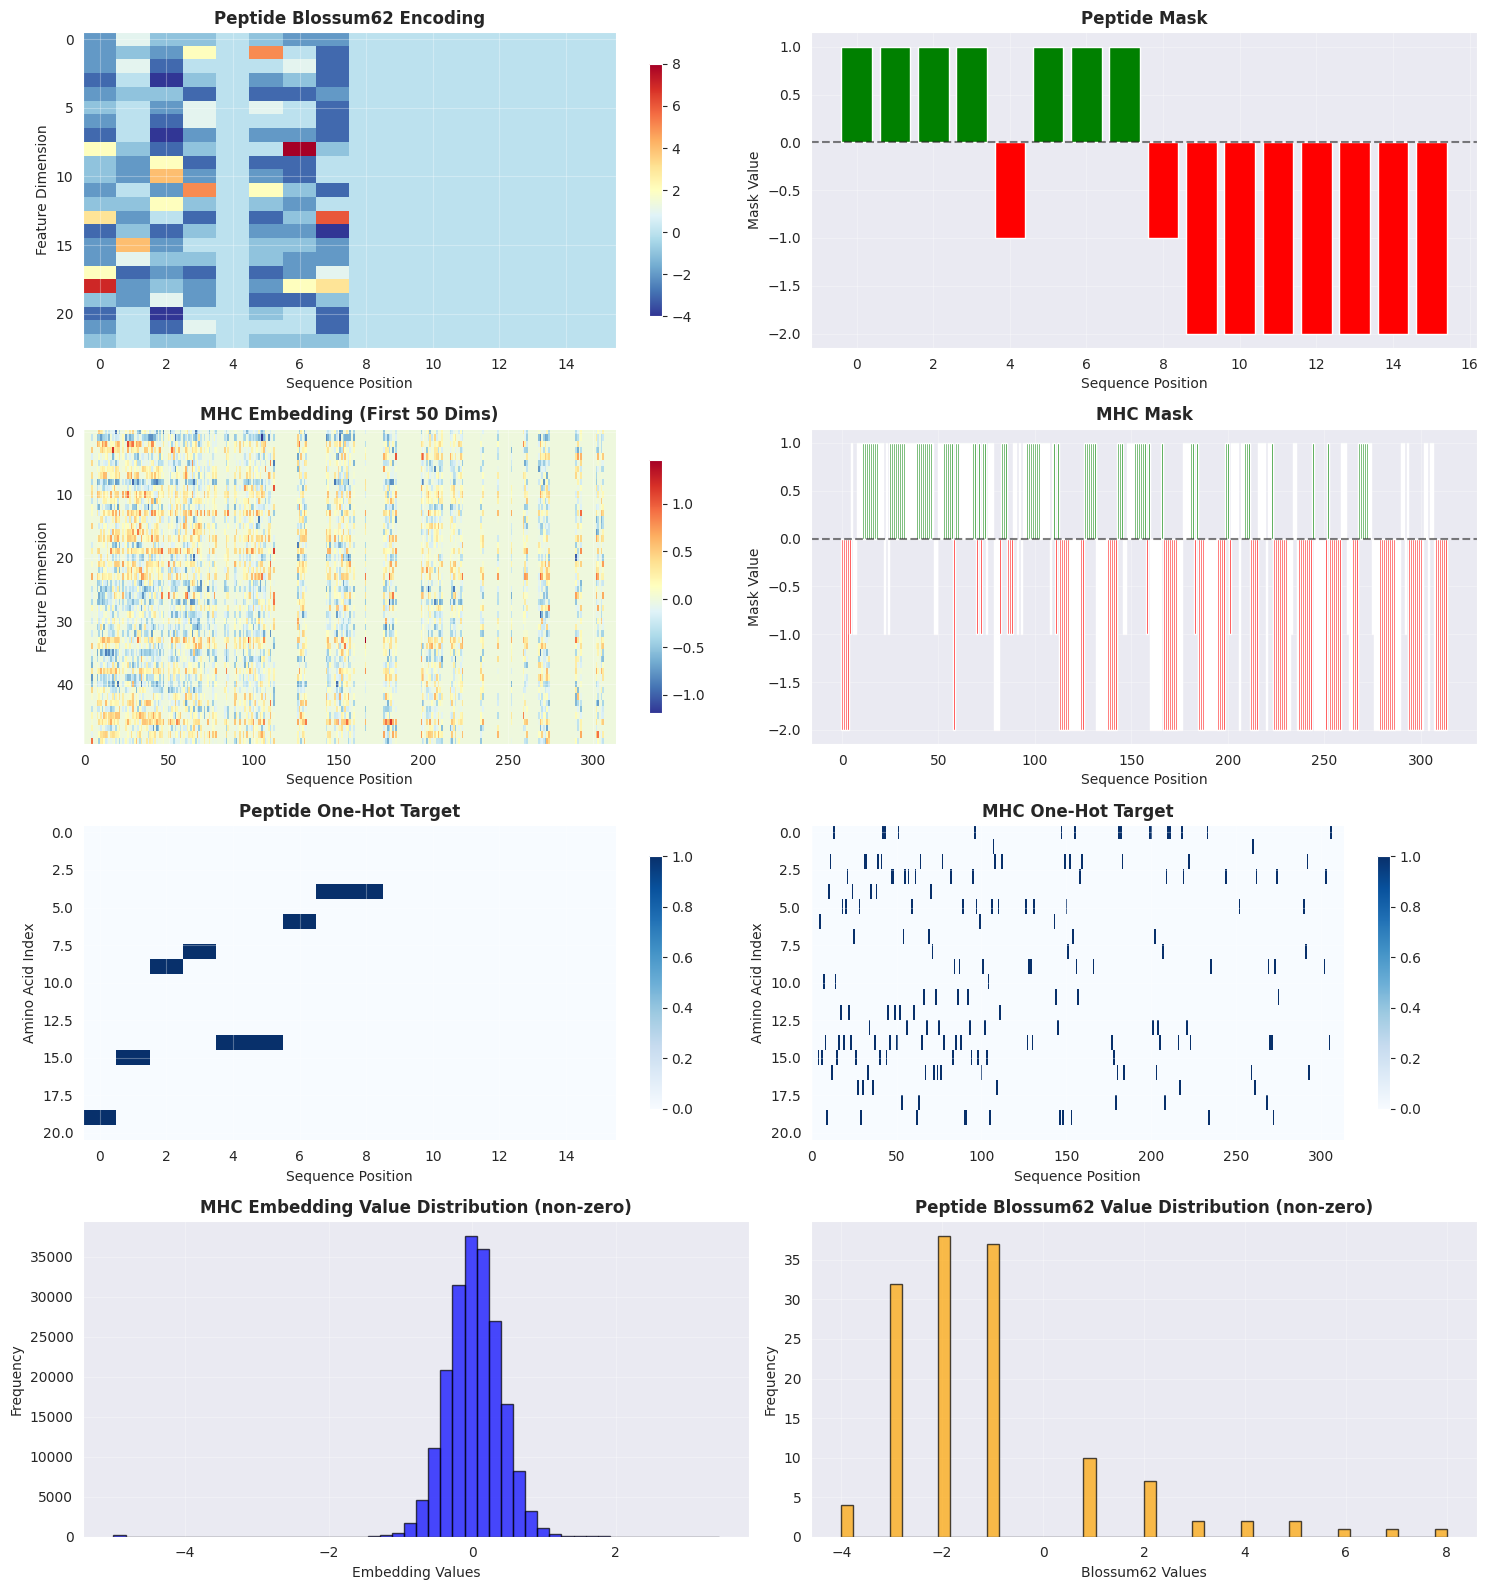


Sample Statistics:
Label: 1.000
Peptide length (non-padded): 7
MHC length (non-padded): 154
Peptide Blossum62 range: [-4.000, 8.000]
MHC embedding range: [-5.000, 3.440]
MHC embedding features below -500: 0
MHC embedding features above 500: 0

--- MHC Embedding Features Below -1000 ---
None found.


--- Visualization of Batch from DataGenerator Pipeline ---
This is the reference batch. Compare it to the TFRecord plots above.


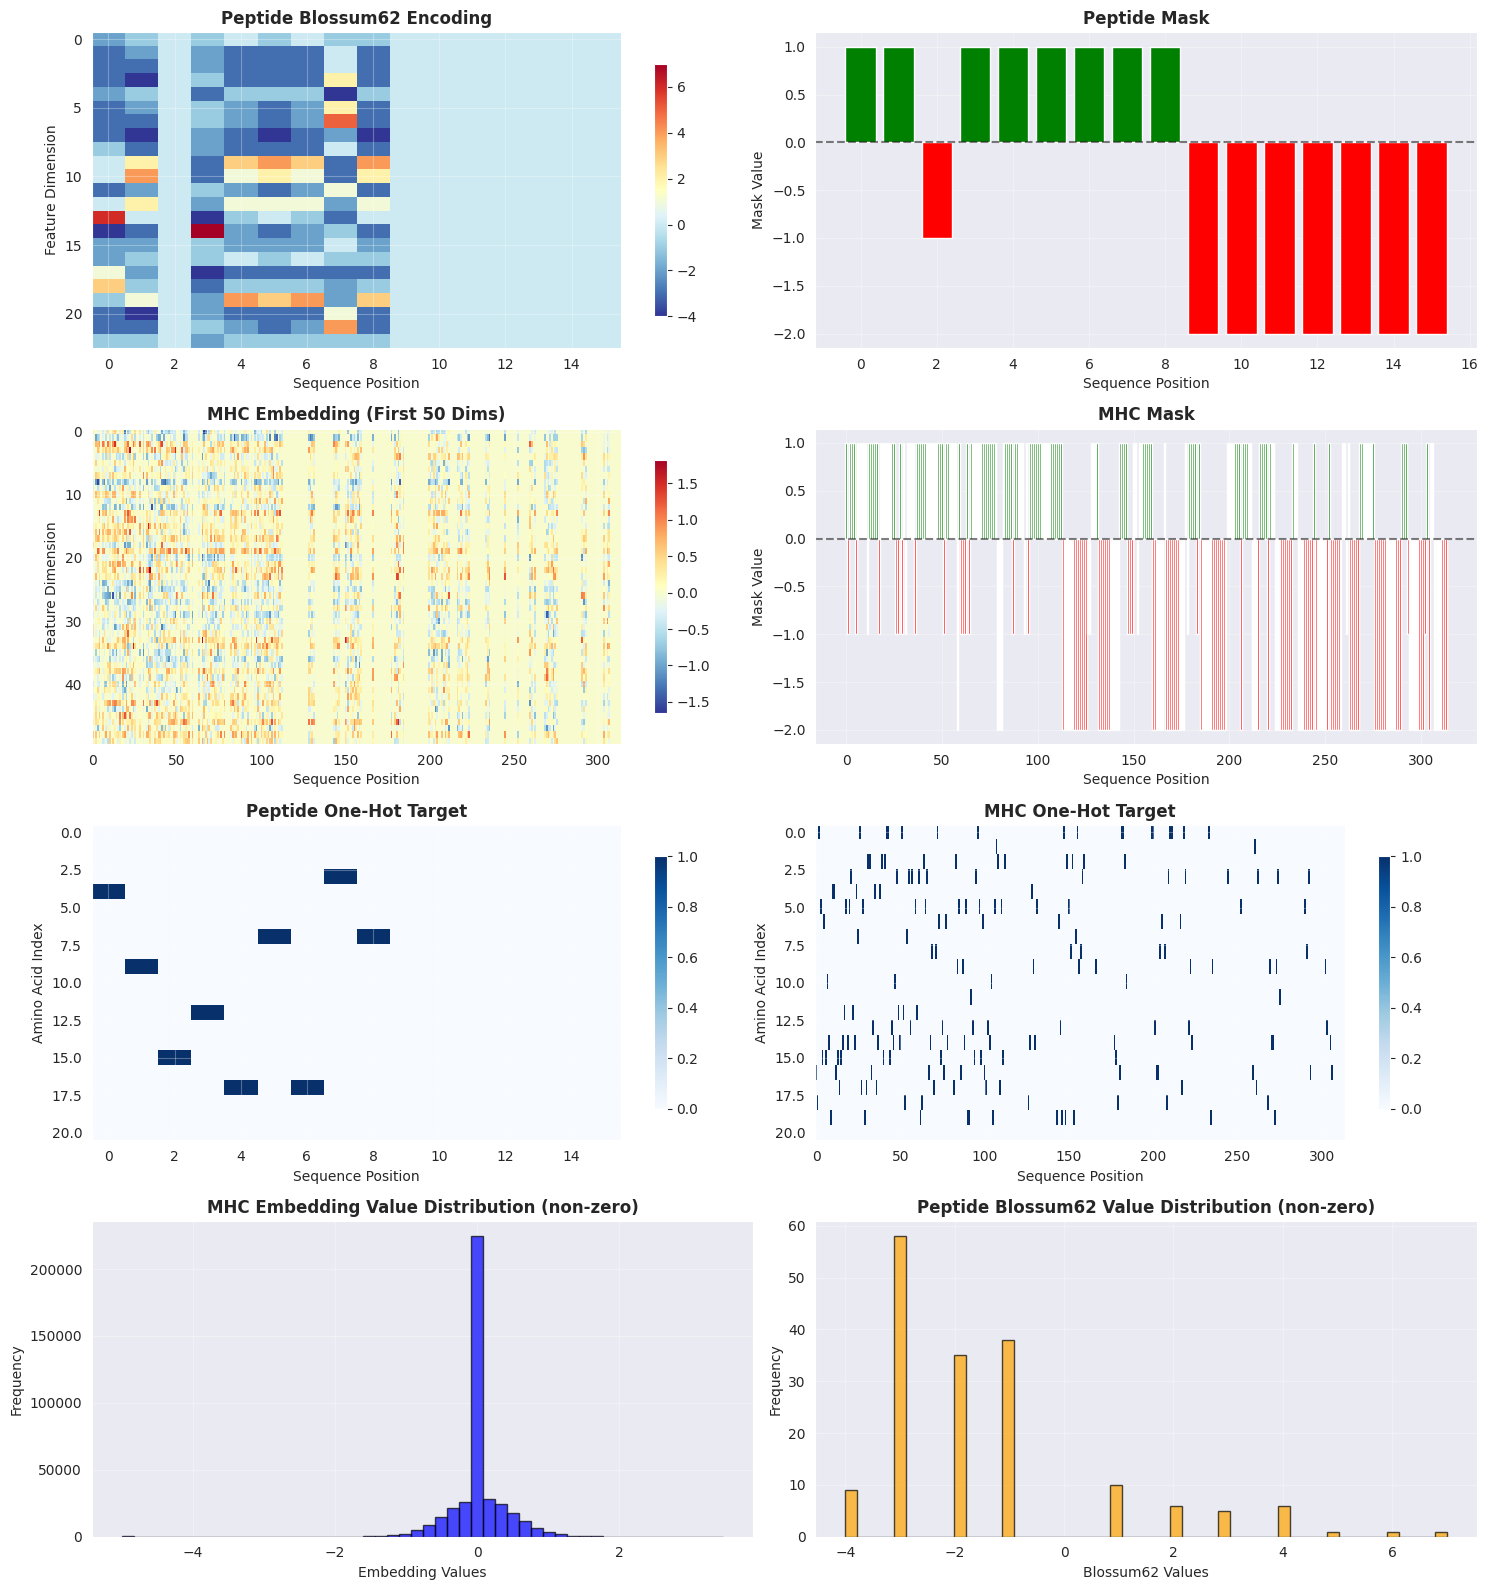


Sample Statistics:
Label: 1.000
Peptide length (non-padded): 8
MHC length (non-padded): 157
Peptide Blossum62 range: [-4.000, 7.000]
MHC embedding range: [-5.000, 3.468]
MHC embedding features below -500: 0
MHC embedding features above 500: 0

--- MHC Embedding Features Below -1000 ---
None found.
DataGen pep_ohe at padding positions:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

TFRecord pep_ohe at padding positions:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

DataGen pep_ohe at valid position (column 20 should be 0):
Sum: 1.0
Position 20: 0.0

TFRecord pep_ohe at valid position (column 20 should be 0):
Sum: 1.0
Position 20: 0.0


In [97]:
# ============================================================================
# Compare tfrecords with DataGenerator outputs
# ============================================================================
def plot_sample_features(sample_batch):
    """Plot features of a sample batch with improved visualizations."""
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))  # Changed from 3x2 to 4x2
    # Define better colormaps
    feature_cmap = 'RdYlBu_r'  # Red-Yellow-Blue for feature values
    mask_cmap = 'RdGy'  # Red-Gray for masks
    onehot_cmap = 'Blues'  # Blues for one-hot encodings

    # Peptide Blossom62 (transposed)
    pep_blossom = sample_batch['pep_blossom62'][0].numpy().T  # Transpose: (features, positions)
    im1 = axes[0, 0].imshow(pep_blossom, aspect='auto', cmap=feature_cmap, interpolation='nearest')
    axes[0, 0].set_title('Peptide Blossum62 Encoding', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Sequence Position')
    axes[0, 0].set_ylabel('Feature Dimension')
    plt.colorbar(im1, ax=axes[0, 0], shrink=0.8)

    # Peptide Mask (as bar plot)
    pep_mask = sample_batch['pep_mask'][0].numpy()
    axes[0, 1].bar(range(len(pep_mask)), pep_mask, color=['red' if x < 0 else 'green' if x > 0 else 'gray' for x in pep_mask])
    axes[0, 1].set_title('Peptide Mask', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Sequence Position')
    axes[0, 1].set_ylabel('Mask Value')
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # MHC Embedding (transposed, showing first 50 dimensions for clarity)
    mhc_emb_full = sample_batch['mhc_emb'][0].numpy()
    mhc_emb = mhc_emb_full.T[:50, :]  # Show first 50 dims, transposed
    im2 = axes[1, 0].imshow(mhc_emb, aspect='auto', cmap=feature_cmap, interpolation='nearest')
    axes[1, 0].set_title('MHC Embedding (First 50 Dims)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Sequence Position')
    axes[1, 0].set_ylabel('Feature Dimension')
    plt.colorbar(im2, ax=axes[1, 0], shrink=0.8)

    # MHC Mask (as bar plot)
    mhc_mask = sample_batch['mhc_mask'][0].numpy()
    axes[1, 1].bar(range(len(mhc_mask)), mhc_mask, color=['red' if x < 0 else 'green' if x > 0 else 'gray' for x in mhc_mask])
    axes[1, 1].set_title('MHC Mask', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Sequence Position')
    axes[1, 1].set_ylabel('Mask Value')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Peptide One-Hot Target (transposed)
    pep_ohe = sample_batch['pep_ohe_target'][0].numpy().T  # Transpose: (amino_acids, positions)
    im3 = axes[2, 0].imshow(pep_ohe, aspect='auto', cmap=onehot_cmap, interpolation='nearest')
    axes[2, 0].set_title('Peptide One-Hot Target', fontsize=12, fontweight='bold')
    axes[2, 0].set_xlabel('Sequence Position')
    axes[2, 0].set_ylabel('Amino Acid Index')
    plt.colorbar(im3, ax=axes[2, 0], shrink=0.8)

    # MHC One-Hot Target (transposed)
    mhc_ohe = sample_batch['mhc_ohe_target'][0].numpy().T  # Transpose: (amino_acids, positions)
    im4 = axes[2, 1].imshow(mhc_ohe, aspect='auto', cmap=onehot_cmap, interpolation='nearest')
    axes[2, 1].set_title('MHC One-Hot Target', fontsize=12, fontweight='bold')
    axes[2, 1].set_xlabel('Sequence Position')
    axes[2, 1].set_ylabel('Amino Acid Index')
    plt.colorbar(im4, ax=axes[2, 1], shrink=0.8)

    # NEW: Distribution plots (excluding zeros)
    # MHC Embedding distribution
    mhc_emb_nonzero = mhc_emb_full[mhc_emb_full != 0]
    mhc_emb_nonzero = np.clip(mhc_emb_nonzero, -1000, 1000)
    axes[3, 0].hist(mhc_emb_nonzero.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[3, 0].set_title('MHC Embedding Value Distribution (non-zero)', fontsize=12, fontweight='bold')
    axes[3, 0].set_xlabel('Embedding Values')
    axes[3, 0].set_ylabel('Frequency')
    axes[3, 0].grid(True, alpha=0.3)

    # Peptide Blossom62 distribution
    pep_blossom_nonzero = pep_blossom[pep_blossom != 0]
    axes[3, 1].hist(pep_blossom_nonzero.flatten(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[3, 1].set_title('Peptide Blossum62 Value Distribution (non-zero)', fontsize=12, fontweight='bold')
    axes[3, 1].set_xlabel('Blossum62 Values')
    axes[3, 1].set_ylabel('Frequency')
    axes[3, 1].grid(True, alpha=0.3)

    # Add grid for better readability (excluding histograms which already have grid)
    for i, ax in enumerate(axes.flat[:-2]):  # Skip the last two histogram plots
        if hasattr(ax, 'grid'):
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\nSample Statistics:")
    print(f"Label: {sample_batch['labels'][0].numpy()[0]:.3f}")
    print(f"Peptide length (non-padded): {np.sum(sample_batch['pep_mask'][0].numpy() > 0)}")
    print(f"MHC length (non-padded): {np.sum(sample_batch['mhc_mask'][0].numpy() > 0)}")
    print(f"Peptide Blossum62 range: [{pep_blossom.min():.3f}, {pep_blossom.max():.3f}]")
    print(f"MHC embedding range: [{mhc_emb_full.min():.3f}, {mhc_emb_full.max():.3f}]")

    # print the number of emb features that are below -500 and above 500
    print(f"MHC embedding features below -500: {np.sum(mhc_emb_full < -500)}")
    print(f"MHC embedding features above 500: {np.sum(mhc_emb_full > 500)}")

    # Print the samples with embedding features below -1000
    print("\n--- MHC Embedding Features Below -1000 ---")
    below_indices = np.argwhere(mhc_emb_full < -1000)
    if len(below_indices) > 0:
        for pos, feat in below_indices:
            value = mhc_emb_full[pos, feat]
            print(f"Position {pos}, Feature {feat}: {value:.3f}")
    else:
        print("None found.")
#
#
#
# plot_sample_features(sample_batch)
# ============================================================================
# DEBUGGING: TFRecord Pipeline vs. DataGenerator Pipeline
# ============================================================================
# The goal is to isolate why the TFRecord training behaves differently.
# We will fetch one batch from each pipeline and visualize them side-by-side.
print("Attempting to fetch batch from DataGenerator...")
datagen_batch = train_generator_infer[1]
print("Successfully fetched batch.")

print("\n--- Starting Pipeline Debugging ---")

# 1. Get one batch from the TFRecord-based dataset
# This represents what the model ACTUALLY sees during TFRecord training
try:
    tfrecord_batch = next(iter(train_dataset_tf))
    print("Successfully fetched one batch from the TFRecord dataset.")
except tf.errors.OutOfRangeError:
    print("Error: The TFRecord dataset is empty. Cannot fetch a batch.")
    tfrecord_batch = None
except Exception as e:
    print(f"An error occurred while fetching from the TFRecord dataset: {e}")
    tfrecord_batch = None

# 2. Get one batch from the DataGenerator
# This is our "ground truth" reference for what the data SHOULD look like
try:
    # We use train_generator_infer because it has masking enabled, just like the TFRecord pipeline.
    datagen_batch = train_generator_infer[0]
    print("Successfully fetched one batch from the DataGenerator.")
except Exception as e:
    print(f"An error occurred while fetching from the DataGenerator: {e}")
    datagen_batch = None

# 3. Visualize and compare the two batches
print("\n\n--- Visualization of Batch from TFRecord Pipeline ---")
print("Inspect these plots and stats carefully. This is what your model gets from the TFRecord files.")
plot_sample_features(tfrecord_batch)

print("\n\n--- Visualization of Batch from DataGenerator Pipeline ---")
print("This is the reference batch. Compare it to the TFRecord plots above.")
plot_sample_features(datagen_batch)

datagen_batch = train_generator_infer[0]
tfrecord_batch = next(iter(train_dataset_tf))

# Check padding positions have all zeros
pep_pad_idx = np.where(datagen_batch['pep_mask'][0].numpy() == PAD_TOKEN)[0]
if len(pep_pad_idx) > 0:
    print("DataGen pep_ohe at padding positions:")
    print(datagen_batch['pep_ohe_target'][0].numpy()[pep_pad_idx[0]])

    print("\nTFRecord pep_ohe at padding positions:")
    print(tfrecord_batch['pep_ohe_target'][0].numpy()[pep_pad_idx[0]])

    # Both should print: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

# Check valid positions have 1 in first 20 dims, 0 in position 20
pep_valid_idx = np.where(datagen_batch['pep_mask'][0].numpy() == NORM_TOKEN)[0]
if len(pep_valid_idx) > 0:
    print("\nDataGen pep_ohe at valid position (column 20 should be 0):")
    print(f"Sum: {datagen_batch['pep_ohe_target'][0].numpy()[pep_valid_idx[0]].sum()}")
    print(f"Position 20: {datagen_batch['pep_ohe_target'][0].numpy()[pep_valid_idx[0], 20]}")

    print("\nTFRecord pep_ohe at valid position (column 20 should be 0):")
    print(f"Sum: {tfrecord_batch['pep_ohe_target'][0].numpy()[pep_valid_idx[0]].sum()}")
    print(f"Position 20: {tfrecord_batch['pep_ohe_target'][0].numpy()[pep_valid_idx[0], 20]}")


In [ ]:
# ============================================================================
# TRAINING LOOP
# ============================================================================
train_steps = metadata['train_samples'] // batch_size
val_steps = len(val_df)//batch_size

print(f"\nCreated TFRecord datasets:")
print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {val_steps}")
print(f"Batch size: {batch_size}")


# Metrics for tracking
train_metrics = {
    'auc': tf.keras.metrics.AUC(), 'acc': tf.metrics.BinaryAccuracy(), 'mcc': BinaryMCC(),
    'loss': tf.keras.metrics.Mean(name='loss'), 'pep_recon_loss': tf.keras.metrics.Mean(name='pep_recon_loss'),
    'mhc_recon_loss': tf.keras.metrics.Mean(name='mhc_recon_loss'), 'class_loss': tf.keras.metrics.Mean(name='class_loss'),
}
val_metrics = {
    'auc': tf.keras.metrics.AUC(), 'acc': tf.metrics.BinaryAccuracy(), 'mcc': BinaryMCC(),
    'loss': tf.keras.metrics.Mean(name='loss'), 'pep_recon_loss': tf.keras.metrics.Mean(name='pep_recon_loss'),
    'mhc_recon_loss': tf.keras.metrics.Mean(name='mhc_recon_loss'), 'class_loss': tf.keras.metrics.Mean(name='class_loss'),
}

print("\nModel Summary:")
model.summary()
best_val_auc = -np.inf
patience_counter = 0
model_save_path = "best_model_tf_300k_seed1.keras"

history = {f"{key}": [] for key in train_metrics.keys()}
history.update({f"val_{key}": [] for key in val_metrics.keys()})

print("\nStarting training with TFRecord pipeline and dynamic masking...")
for epoch in range(epochs):
    for metric in train_metrics.values(): metric.reset_state()
    for metric in val_metrics.values(): metric.reset_state()

    # Training
    pbar = tqdm(train_dataset_tf, total=train_steps, desc=f"Epoch {epoch + 1}/{epochs}")
    for batch_data in pbar:
        total_loss, pep_loss, mhc_loss, class_loss, metrics = train_step(
            batch_data, model, optimizer, binary_loss_fn, train_metrics
        )
        pbar.set_postfix({
            "Loss": f"{train_metrics['loss'].result():.4f}", "AUC": f"{train_metrics['auc'].result():.4f}",
            "ACC": f"{train_metrics['acc'].result():.4f}", "MCC": f"{train_metrics['mcc'].result():.4f}",
        })

    # Validation
    pbar_val = tqdm(range(val_steps), desc=f"Epoch {epoch + 1}/{epochs} - Val", total=val_steps)
    for batch_idx in pbar_val:
        batch_data = val_generator[batch_idx]
        val_total_loss, val_pep_loss, val_mhc_loss, val_class_loss, _ = val_step_optimized(
            batch_data, model, binary_loss_fn, val_metrics
        )
        pbar_val.set_postfix({
            "Val_Loss": f"{val_metrics['loss'].result():.4f}", "Val_AUC": f"{val_metrics['auc'].result():.4f}",
            "Val_ACC": f"{val_metrics['acc'].result():.4f}", "Val_MCC": f"{val_metrics['mcc'].result():.4f}",
        })

    train_results = {key: value.result().numpy() for key, value in train_metrics.items()}
    val_results = {key: value.result().numpy() for key, value in val_metrics.items()}
    for key, value in train_results.items(): history[key].append(value)
    for key, value in val_results.items(): history[f"val_{key}"].append(value)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Loss: {train_results['loss']:.4f} - AUC: {train_results['auc']:.4f} - ACC: {train_results['acc']:.4f} - MCC: {train_results['mcc']:.4f} - "
          f"Val Loss: {val_results['loss']:.4f} - Val AUC: {val_results['auc']:.4f} - Val ACC: {val_results['acc']:.4f} - Val MCC: {val_results['mcc']:.4f}")

    current_val_auc = val_results['auc']
    if current_val_auc > best_val_auc:
        print(f"Validation AUC improved from {best_val_auc:.4f} to {current_val_auc:.4f}. Saving model...")
        best_val_auc = current_val_auc
        patience_counter = 0
        model.save(model_save_path)
    else:
        patience_counter += 1
        print(f"Validation AUC did not improve. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered. Training has been halted.")
        break
print("Training finished!")

# Plot training history
print("\nPlotting training history...")
history_df = pd.DataFrame(history)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training and Validation Metrics', fontsize=20)

# Plot Total Loss
axes[0, 0].plot(history_df.index, history_df['loss'], label='Train Loss')
axes[0, 0].plot(history_df.index, history_df['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot AUC
axes[0, 1].plot(history_df.index, history_df['auc'], label='Train AUC')
axes[0, 1].plot(history_df.index, history_df['val_auc'], label='Validation AUC')
axes[0, 1].set_title('AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Reconstruction Losses
axes[1, 0].plot(history_df.index, history_df['pep_recon_loss'], label='Train Peptide Recon Loss')
axes[1, 0].plot(history_df.index, history_df['val_pep_recon_loss'], label='Val Peptide Recon Loss')
axes[1, 0].plot(history_df.index, history_df['mhc_recon_loss'], label='Train MHC Recon Loss', linestyle='--')
axes[1, 0].plot(history_df.index, history_df['val_mhc_recon_loss'], label='Val MHC Recon Loss', linestyle='--')
axes[1, 0].set_title('Reconstruction Losses')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Classification Loss
axes[1, 1].plot(history_df.index, history_df['class_loss'], label='Train Classification Loss')
axes[1, 1].plot(history_df.index, history_df['val_class_loss'], label='Validation Classification Loss')
axes[1, 1].set_title('Classification Loss (Asymmetric)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
model_save_path = "best_model_tf_300k_seed1.keras"
# load best model:
print(f"\nLoading the best model from {model_save_path} for final evaluation.")
model = tf.keras.models.load_model(
    model_save_path,
    custom_objects={
        'SelfAttentionWith2DMask': SelfAttentionWith2DMask,
        'AsymmetricPenaltyBinaryCrossentropy': AsymmetricPenaltyBinaryCrossentropy,
        'AddGaussianNoise': AddGaussianNoise,
        'PositionalEncoding': PositionalEncoding,
        'GlobalMeanPooling1D': GlobalMeanPooling1D,
        'GlobalSTDPooling1D': GlobalSTDPooling1D,
        'GlobalMaxPooling1D': GlobalMaxPooling1D,
        'MaskedEmbedding': MaskedEmbedding,
        'BinaryMCC': BinaryMCC
    }
)




In [ ]:
# ============================================================================
# VISUALIZATION
# ============================================================================
# Visualize attention weights
print("\nVisualizing attention weights...")

# Get attention weights from a validation batch
batch_data = val_generator[0]
x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                batch_data['mhc_emb'], batch_data['mhc_mask'],
                batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
predictions = model(x_batch_list, training=False)
attn_weights = predictions['attn_weights'].numpy()
sample_labels = batch_data['labels'].numpy().flatten()

# Also get the masks for analysis
pep_mask = batch_data['pep_mask'].numpy()
mhc_mask = batch_data['mhc_mask'].numpy()

# Plot attention weights for first few samples
num_samples_to_plot = 3
fig, axes = plt.subplots(1, num_samples_to_plot, figsize=(20, 6))
fig.suptitle('Attention Weight Visualizations (Head 0)', fontsize=16)

for i in range(num_samples_to_plot):
    # Take first attention head
    attn_matrix = attn_weights[i, 0, :, :]  # Shape: (seq_len, seq_len)

    # Use different scaling to see weak patterns
    im = axes[i].imshow(attn_matrix, cmap='Blues', aspect='auto', vmin=0, vmax=0.1)
    axes[i].set_title(f'Sample {i + 1} (Label: {int(sample_labels[i])})')
    axes[i].set_xlabel('Key Position')
    axes[i].set_ylabel('Query Position')

    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

    # Add grid to separate peptide and MHC regions
    axes[i].axhline(y=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)
    axes[i].axvline(x=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Visualize latent space (simple 2D projection using PCA)
print("\nVisualizing latent space...")

# Collect latent vectors and labels
latent_vectors = []
true_labels = []

for batch_idx in range(min(10, len(val_generator))):  # Limit for demo
    batch_data = val_generator[batch_idx]
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
    predictions = model(x_batch_list, training=False)
    latent_vectors.append(predictions['latent_vector'].numpy())
    true_labels.append(batch_data['labels'].numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
true_labels = np.concatenate(true_labels, axis=0).flatten()

In [ ]:
print(true_labels)

In [ ]:
# Simple UMAP visualization
import umap
import matplotlib.pyplot as plt

# UMAP embedding
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(latent_vectors)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                     c=true_labels, alpha=0.7, s=5)
plt.colorbar(scatter, label='Binding Label')
plt.title('UMAP Projection of Latent Space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
def analyze_attention_patterns(attn_weights, pep_len, mhc_len, sample_idx=0, head_idx=0):
    """Analyze and visualize attention patterns in detail"""

    attn_matrix = attn_weights[sample_idx, head_idx, :, :]
    total_len = pep_len + mhc_len

    # Extract different attention regions
    pep_to_pep = attn_matrix[:pep_len, :pep_len]  # Upper-left
    pep_to_mhc = attn_matrix[:pep_len, pep_len:]  # Upper-right
    mhc_to_pep = attn_matrix[pep_len:, :pep_len]  # Lower-left
    mhc_to_mhc = attn_matrix[pep_len:, pep_len:]  # Lower-right

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Detailed Attention Analysis - Sample {sample_idx}, Head {head_idx}', fontsize=16)

    # Full attention matrix
    im1 = axes[0, 0].imshow(attn_matrix, cmap='Blues', aspect='auto')
    axes[0, 0].set_title('Full Attention Matrix')
    axes[0, 0].set_xlabel('Key Position')
    axes[0, 0].set_ylabel('Query Position')
    axes[0, 0].axhline(y=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].axvline(x=pep_len - 0.5, color='red', linestyle='--', alpha=0.7)
    plt.colorbar(im1, ax=axes[0, 0])

    # Peptide to Peptide (should be dim due to 0.1 scaling)
    im2 = axes[0, 1].imshow(pep_to_pep, cmap='Blues', aspect='auto')
    axes[0, 1].set_title('Peptide → Peptide\n(Self-attention, scaled by 0.1)')
    axes[0, 1].set_xlabel('Peptide Key Position')
    axes[0, 1].set_ylabel('Peptide Query Position')
    plt.colorbar(im2, ax=axes[0, 1])

    # Peptide to MHC (should be strong)
    im3 = axes[0, 2].imshow(pep_to_mhc, cmap='Blues', aspect='auto')
    axes[0, 2].set_title('Peptide → MHC\n(Cross-attention, full strength)')
    axes[0, 2].set_xlabel('MHC Key Position')
    axes[0, 2].set_ylabel('Peptide Query Position')
    plt.colorbar(im3, ax=axes[0, 2])

    # MHC to Peptide (should be strong)
    im4 = axes[1, 0].imshow(mhc_to_pep, cmap='Blues', aspect='auto')
    axes[1, 0].set_title('MHC → Peptide\n(Cross-attention, full strength)')
    axes[1, 0].set_xlabel('Peptide Key Position')
    axes[1, 0].set_ylabel('MHC Query Position')
    plt.colorbar(im4, ax=axes[1, 0])

    # MHC to MHC (depends on self_attn_mhc parameter)
    im5 = axes[1, 1].imshow(mhc_to_mhc, cmap='Blues', aspect='auto')
    axes[1, 1].set_title('MHC → MHC\n(Self-attention)')
    axes[1, 1].set_xlabel('MHC Key Position')
    axes[1, 1].set_ylabel('MHC Query Position')
    plt.colorbar(im5, ax=axes[1, 1])

    # Statistics plot
    axes[1, 2].bar(['Pep→Pep', 'Pep→MHC', 'MHC→Pep', 'MHC→MHC'],
                   [pep_to_pep.mean(), pep_to_mhc.mean(),
                    mhc_to_pep.mean(), mhc_to_mhc.mean()])
    axes[1, 2].set_title('Mean Attention Strength by Region')
    axes[1, 2].set_ylabel('Mean Attention Weight')
    axes[1, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\nAttention Statistics for Sample {sample_idx}, Head {head_idx}:")
    print(f"Peptide → Peptide: mean={pep_to_pep.mean():.4f}, max={pep_to_pep.max():.4f}")
    print(f"Peptide → MHC: mean={pep_to_mhc.mean():.4f}, max={pep_to_mhc.max():.4f}")
    print(f"MHC → Peptide: mean={mhc_to_pep.mean():.4f}, max={mhc_to_pep.max():.4f}")
    print(f"MHC → MHC: mean={mhc_to_mhc.mean():.4f}, max={mhc_to_mhc.max():.4f}")

    return attn_matrix


def check_mask_effects(p_mask, m_mask, sample_idx=0):
    """Check how masking affects the attention patterns"""

    pep_mask_sample = p_mask[sample_idx]
    mhc_mask_sample = m_mask[sample_idx]

    print(f"\nMask Analysis for Sample {sample_idx}:")
    print(f"Peptide mask: {pep_mask_sample}")
    print(f"MHC mask: {mhc_mask_sample}")
    print(f"Valid peptide positions: {np.sum(pep_mask_sample > 0)}")
    print(f"Valid MHC positions: {np.sum(mhc_mask_sample > 0)}")
    print(f"Masked peptide positions: {np.sum(pep_mask_sample == MASK_TOKEN)}")
    print(f"Padded peptide positions: {np.sum(pep_mask_sample == PAD_TOKEN)}")
    print(f"Padded MHC positions: {np.sum(mhc_mask_sample == PAD_TOKEN)}")


# Analyze attention patterns and mask effects
analyze_attention_patterns(attn_weights, pep_len, mhc_len, sample_idx=0, head_idx=0)
check_mask_effects(pep_mask, mhc_mask, sample_idx=0)

# Demonstrate dynamic masking effects
print("\nDemonstrating dynamic masking effects...")
masked_batch = train_generator_infer[0]  # Get a training batch with masking applied
print(f"Sample masks in training batch:")
print(f"Peptide mask values: {np.unique(masked_batch['pep_mask'][0])}")
print(f"MHC mask values: {np.unique(masked_batch['mhc_mask'][0])}")
print(
    f"Positions with MASK_TOKEN ({MASK_TOKEN}): Peptide={np.sum(masked_batch['pep_mask'][0] == MASK_TOKEN)}, MHC={np.sum(masked_batch['mhc_mask'][0] == MASK_TOKEN)}")


In [ ]:
# Analyse predictions per allele:
# Analyze predictions per allele across all validation batches
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import defaultdict

allele_counts = defaultdict(lambda: {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0})
total_samples = 0

for batch_idx in range(len(train_generator_infer)):
    batch_data = val_generator[batch_idx]
    val_x = [
        batch_data['pep_blossom62'], batch_data['pep_mask'],
        batch_data['mhc_emb'], batch_data['mhc_mask'],
        batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']
    ]
    preds = model(val_x, training=False)
    pred_labels = (preds['cls_ypred'].numpy().flatten() >= 0.5).astype(int)
    true_labels = batch_data['labels'].numpy().flatten()

    n = int(true_labels.shape[0])
    total_samples += n
    batch_start_idx = batch_idx * val_generator.batch_size
    val_df_batch = val_df.iloc[batch_start_idx:batch_start_idx + n, :].copy()
    val_df_batch['pred_label'] = pred_labels
    val_df_batch['true_label'] = true_labels

    for allele, allele_df in val_df_batch.groupby('allele'):
        if len(allele_df) == 0:
            continue
        tp = int(np.sum((allele_df['pred_label'] == 1) & (allele_df['true_label'] == 1)))
        tn = int(np.sum((allele_df['pred_label'] == 0) & (allele_df['true_label'] == 0)))
        fp = int(np.sum((allele_df['pred_label'] == 1) & (allele_df['true_label'] == 0)))
        fn = int(np.sum((allele_df['pred_label'] == 0) & (allele_df['true_label'] == 1)))
        allele_counts[allele]['TP'] += tp
        allele_counts[allele]['TN'] += tn
        allele_counts[allele]['FP'] += fp
        allele_counts[allele]['FN'] += fn

confusion_df = pd.DataFrame.from_dict(allele_counts, orient='index')
confusion_df.index.name = 'Allele'
confusion_df = confusion_df[['TP', 'TN', 'FP', 'FN']].astype(int)

# Metrics
eps = 1e-12
denom = confusion_df[['TP', 'TN', 'FP', 'FN']].sum(axis=1).clip(lower=eps)
confusion_df['Accuracy'] = (confusion_df['TP'] + confusion_df['TN']) / denom
confusion_df['Precision'] = confusion_df['TP'] / (confusion_df['TP'] + confusion_df['FP']).clip(lower=eps)
confusion_df['Recall'] = confusion_df['TP'] / (confusion_df['TP'] + confusion_df['FN']).clip(lower=eps)
confusion_df = confusion_df.fillna(0.0).sort_index()

# Plot confusion matrix heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(confusion_df[['TP', 'TN', 'FP', 'FN']], annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix Counts per Allele (All Validation Batches)')
ax1.set_ylabel('Allele')
ax1.set_xlabel('Counts')

sns.heatmap(confusion_df[['Accuracy', 'Precision', 'Recall']], annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2)
ax2.set_title('Performance Metrics per Allele (All Validation Batches)')
ax2.set_ylabel('Allele')
ax2.set_xlabel('Metrics')

plt.tight_layout()
plt.show()

allele_list = list(confusion_df.index)
print("\nValidation analysis (all batches):")
print(f"Total samples: {total_samples}")
print(f"Number of unique alleles: {len(allele_list)}")
print(f"Alleles: {sorted(allele_list)}")


In [ ]:
def per_allele_predictions(data_generator, threshold=0.5):
    # Analyze predictions per allele across all validation batches
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    from collections import defaultdict

    allele_counts = defaultdict(lambda: {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0})
    total_samples = 0

    for batch_idx in range(len(data_generator)):
        batch_data = data_generator[batch_idx]
        val_x = [
            batch_data['pep_blossom62'], batch_data['pep_mask'],
            batch_data['mhc_emb'], batch_data['mhc_mask'],
            batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']
        ]
        preds = model(val_x, training=False)
        pred_labels = (preds['cls_ypred'].numpy().flatten() >= 0.7).astype(int)
        true_labels = batch_data['labels'].numpy().flatten()

        n = int(true_labels.shape[0])
        total_samples += n
        batch_start_idx = batch_idx * data_generator.batch_size
        val_df_batch = val_df.iloc[batch_start_idx:batch_start_idx + n, :].copy()
        val_df_batch['pred_label'] = pred_labels
        val_df_batch['true_label'] = true_labels

        for allele, allele_df in val_df_batch.groupby('allele'):
            if len(allele_df) == 0:
                continue
            tp = int(np.sum((allele_df['pred_label'] == 1) & (allele_df['true_label'] == 1)))
            tn = int(np.sum((allele_df['pred_label'] == 0) & (allele_df['true_label'] == 0)))
            fp = int(np.sum((allele_df['pred_label'] == 1) & (allele_df['true_label'] == 0)))
            fn = int(np.sum((allele_df['pred_label'] == 0) & (allele_df['true_label'] == 1)))
            allele_counts[allele]['TP'] += tp
            allele_counts[allele]['TN'] += tn
            allele_counts[allele]['FP'] += fp
            allele_counts[allele]['FN'] += fn

    confusion_df = pd.DataFrame.from_dict(allele_counts, orient='index')
    confusion_df.index.name = 'Allele'
    confusion_df = confusion_df[['TP', 'TN', 'FP', 'FN']].astype(int)

    # Metrics
    eps = 1e-12
    denom = confusion_df[['TP', 'TN', 'FP', 'FN']].sum(axis=1).clip(lower=eps)
    confusion_df['Accuracy'] = (confusion_df['TP'] + confusion_df['TN']) / denom
    confusion_df['Precision'] = confusion_df['TP'] / (confusion_df['TP'] + confusion_df['FP']).clip(lower=eps)
    confusion_df['Recall'] = confusion_df['TP'] / (confusion_df['TP'] + confusion_df['FN']).clip(lower=eps)
    confusion_df = confusion_df.fillna(0.0).sort_index()

    # Plot confusion matrix heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(confusion_df[['TP', 'TN', 'FP', 'FN']], annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix Counts per Allele (All Validation Batches)')
    ax1.set_ylabel('Allele')
    ax1.set_xlabel('Counts')

    sns.heatmap(confusion_df[['Accuracy', 'Precision', 'Recall']], annot=True, fmt='.3f', cmap='RdYlGn', ax=ax2)
    ax2.set_title('Performance Metrics per Allele (All Validation Batches)')
    ax2.set_ylabel('Allele')
    ax2.set_xlabel('Metrics')

    plt.tight_layout()
    plt.show()

    allele_list = list(confusion_df.index)
    print("\nValidation analysis (all batches):")
    print(f"Total samples: {total_samples}")
    print(f"Number of unique alleles: {len(allele_list)}")
    print(f"Alleles: {sorted(allele_list)}")




In [ ]:
per_allele_predictions(val_generator, threshold=0.7)

In [ ]:
# run predictions on test.parquet
# Load and preprocess test data
print(f"Loading train data from: {train_parquet_path}")

if not os.path.exists(train_parquet_path):
    print(f"Error: Test file not found at {train_parquet_path}")
    raise FileNotFoundError(f"Train parquet file not found: {train_parquet_path}")

test_df = pd.read_parquet(train_parquet_path)
print(f"Train samples: {len(test_df):,}")

# Preprocess test dataframe
test_df = preprocess_df(test_df, seq_map, embed_map)

# Create test generator
test_generator = OptimizedDataGenerator(
    df=test_df,
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=False  # No masking for test
)

print(f"Train batches: {len(test_generator)}")

# Run predictions on test set
print("Running predictions on test set...")
test_preds = []
test_true = []

for batch_idx in range(len(test_generator)):
    batch_data = test_generator[batch_idx]
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
    predictions = model(x_batch_list, training=False)
    test_preds.append(predictions['cls_ypred'].numpy())
    test_true.append(batch_data['labels'].numpy())

test_preds = np.concatenate(test_preds, axis=0).flatten()
test_true = np.concatenate(test_true, axis=0).flatten()

print(f"Generated {len(test_preds)} predictions")

# Calculate metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

roc_auc = roc_auc_score(test_true, test_preds)
precision, recall, _ = precision_recall_curve(test_true, test_preds)
pr_auc = auc(recall, precision)

# Binary predictions for confusion matrix
test_pred_binary = (test_preds >= 0.5).astype(int)

accuracy = accuracy_score(test_true, test_pred_binary)
precision_score_val = precision_score(test_true, test_pred_binary)
recall_score_val = recall_score(test_true, test_pred_binary)
f1_score_val = f1_score(test_true, test_pred_binary)

print(f"\nTest Set Performance:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_score_val:.4f}")
print(f"Recall: {recall_score_val:.4f}")
print(f"F1 Score: {f1_score_val:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_true, test_pred_binary)
print(f"\nConfusion Matrix:")
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

# Comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Test Set Performance Analysis', fontsize=16)

# 1. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(test_true, test_preds)
axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
axes[0, 1].plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})')
axes[0, 1].axhline(y=np.mean(test_true), color='k', linestyle='--', label='Random')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
            xticklabels=['Non-Binder', 'Binder'],
            yticklabels=['Non-Binder', 'Binder'])
axes[0, 2].set_title('Confusion Matrix')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# 4. Prediction Distribution
axes[1, 0].hist(test_preds[test_true == 0], bins=50, alpha=0.7, label='Non-Binders', color='red')
axes[1, 0].hist(test_preds[test_true == 1], bins=50, alpha=0.7, label='Binders', color='blue')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('Prediction Score')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Prediction Score Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Calibration Plot
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(test_true, test_preds, n_bins=10)
axes[1, 1].plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1, 1].set_xlabel('Mean Predicted Probability')
axes[1, 1].set_ylabel('Fraction of Positives')
axes[1, 1].set_title('Calibration Plot')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance by Prediction Confidence
# Bin predictions by confidence and show accuracy
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []
bin_counts = []

for i in range(len(confidence_bins) - 1):
    mask = (test_preds >= confidence_bins[i]) & (test_preds < confidence_bins[i + 1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(test_true[mask], test_pred_binary[mask])
        bin_accuracies.append(bin_acc)
        bin_counts.append(np.sum(mask))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

bars = axes[1, 2].bar(bin_centers, bin_accuracies, width=0.08, alpha=0.7, color='green')
axes[1, 2].set_xlabel('Prediction Score Bin')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Accuracy by Prediction Confidence')
axes[1, 2].grid(True, alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, bin_counts):
    if count > 0:
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'n={count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Per-allele analysis if allele information is available
if '_emb_key' in test_df.columns:
    print("\nPer-allele performance analysis...")

    # Create a dataframe with predictions and alleles
    test_results_df = test_df.copy()
    test_results_df = test_results_df.iloc[:len(test_preds)].copy()
    test_results_df['pred_score'] = test_preds
    test_results_df['pred_label'] = test_pred_binary
    test_results_df['true_label'] = test_true

    # Calculate per-allele metrics
    allele_metrics = []
    for allele in test_results_df['_emb_key'].unique():
        allele_data = test_results_df[test_results_df['_emb_key'] == allele]
        if len(allele_data) > 5:  # Only analyze alleles with sufficient data
            try:
                allele_auc = roc_auc_score(allele_data['true_label'], allele_data['pred_score'])
                allele_acc = accuracy_score(allele_data['true_label'], allele_data['pred_label'])
                allele_metrics.append({
                    'allele': allele,
                    'count': len(allele_data),
                    'auc': allele_auc,
                    'accuracy': allele_acc,
                    'positive_rate': allele_data['true_label'].mean()
                })
            except ValueError:
                # Skip alleles with only one class
                continue

    if allele_metrics:
        allele_metrics_df = pd.DataFrame(allele_metrics)
        allele_metrics_df = allele_metrics_df.sort_values('auc', ascending=False)

        print(f"\nTop 10 alleles by AUC:")
        print(allele_metrics_df.head(10).to_string(index=False))

        # Visualize per-allele performance
        plt.figure(figsize=(15, 8))

        plt.subplot(2, 2, 1)
        plt.scatter(allele_metrics_df['count'], allele_metrics_df['auc'], alpha=0.6)
        plt.xlabel('Number of Test Samples')
        plt.ylabel('AUC')
        plt.title('AUC vs Sample Count per Allele')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.scatter(allele_metrics_df['positive_rate'], allele_metrics_df['auc'], alpha=0.6)
        plt.xlabel('Positive Rate')
        plt.ylabel('AUC')
        plt.title('AUC vs Positive Rate per Allele')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        top_alleles = allele_metrics_df.head(15)
        plt.barh(range(len(top_alleles)), top_alleles['auc'])
        plt.yticks(range(len(top_alleles)), top_alleles['allele'])
        plt.xlabel('AUC')
        plt.title('Top 15 Alleles by AUC')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        plt.hist(allele_metrics_df['auc'], bins=20, alpha=0.7, edgecolor='black')
        plt.axvline(x=allele_metrics_df['auc'].mean(), color='red', linestyle='--',
                   label=f'Mean: {allele_metrics_df["auc"].mean():.3f}')
        plt.xlabel('AUC')
        plt.ylabel('Number of Alleles')
        plt.title('Distribution of Per-Allele AUC')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

print("\nTrain evaluation complete!")


In [ ]:
# run predictions on test.parquet
# Load and preprocess test data
test_parquet_path = os.path.join(parquet_dir, 'test_seed_1.parquet')
print(f"Loading test data from: {test_parquet_path}")

if not os.path.exists(test_parquet_path):
    print(f"Error: Test file not found at {test_parquet_path}")
    raise FileNotFoundError(f"Test parquet file not found: {test_parquet_path}")

test_df = pd.read_parquet(test_parquet_path)
print(f"Test samples: {len(test_df):,}")

# Preprocess test dataframe
test_df = preprocess_df(test_df, seq_map, embed_map)

# Create test generator
test_generator = OptimizedDataGenerator(
    df=test_df,
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=False  # No masking for test
)

print(f"Test batches: {len(test_generator)}")

# Run predictions on test set
print("Running predictions on test set...")
test_preds = []
test_true = []

for batch_idx in range(len(test_generator)):
    batch_data = test_generator[batch_idx]
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
    predictions = model(x_batch_list, training=False)
    test_preds.append(predictions['cls_ypred'].numpy())
    test_true.append(batch_data['labels'].numpy())

test_preds = np.concatenate(test_preds, axis=0).flatten()
test_true = np.concatenate(test_true, axis=0).flatten()

print(f"Generated {len(test_preds)} predictions")

# Calculate metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

roc_auc = roc_auc_score(test_true, test_preds)
precision, recall, _ = precision_recall_curve(test_true, test_preds)
pr_auc = auc(recall, precision)

# Binary predictions for confusion matrix
test_pred_binary = (test_preds >= 0.5).astype(int)

accuracy = accuracy_score(test_true, test_pred_binary)
precision_score_val = precision_score(test_true, test_pred_binary)
recall_score_val = recall_score(test_true, test_pred_binary)
f1_score_val = f1_score(test_true, test_pred_binary)

print(f"\nTest Set Performance:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_score_val:.4f}")
print(f"Recall: {recall_score_val:.4f}")
print(f"F1 Score: {f1_score_val:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_true, test_pred_binary)
print(f"\nConfusion Matrix:")
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")

# Comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Test Set Performance Analysis', fontsize=16)

# 1. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(test_true, test_preds)
axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
axes[0, 1].plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.3f})')
axes[0, 1].axhline(y=np.mean(test_true), color='k', linestyle='--', label='Random')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
            xticklabels=['Non-Binder', 'Binder'],
            yticklabels=['Non-Binder', 'Binder'])
axes[0, 2].set_title('Confusion Matrix')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# 4. Prediction Distribution
axes[1, 0].hist(test_preds[test_true == 0], bins=50, alpha=0.7, label='Non-Binders', color='red')
axes[1, 0].hist(test_preds[test_true == 1], bins=50, alpha=0.7, label='Binders', color='blue')
axes[1, 0].axvline(x=0.5, color='black', linestyle='--', label='Threshold')
axes[1, 0].set_xlabel('Prediction Score')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Prediction Score Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Calibration Plot
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(test_true, test_preds, n_bins=10)
axes[1, 1].plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
axes[1, 1].set_xlabel('Mean Predicted Probability')
axes[1, 1].set_ylabel('Fraction of Positives')
axes[1, 1].set_title('Calibration Plot')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance by Prediction Confidence
# Bin predictions by confidence and show accuracy
confidence_bins = np.linspace(0, 1, 11)
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []
bin_counts = []

for i in range(len(confidence_bins) - 1):
    mask = (test_preds >= confidence_bins[i]) & (test_preds < confidence_bins[i + 1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(test_true[mask], test_pred_binary[mask])
        bin_accuracies.append(bin_acc)
        bin_counts.append(np.sum(mask))
    else:
        bin_accuracies.append(0)
        bin_counts.append(0)

bars = axes[1, 2].bar(bin_centers, bin_accuracies, width=0.08, alpha=0.7, color='green')
axes[1, 2].set_xlabel('Prediction Score Bin')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Accuracy by Prediction Confidence')
axes[1, 2].grid(True, alpha=0.3)

# Add count labels on bars
for bar, count in zip(bars, bin_counts):
    if count > 0:
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'n={count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Per-allele analysis if allele information is available
if '_emb_key' in test_df.columns:
    print("\nPer-allele performance analysis...")

    # Create a dataframe with predictions and alleles
    test_results_df = test_df.copy()
    test_results_df = test_results_df.iloc[:len(test_preds)].copy()
    test_results_df['pred_score'] = test_preds
    test_results_df['pred_label'] = test_pred_binary
    test_results_df['true_label'] = test_true

    # Calculate per-allele metrics
    allele_metrics = []
    for allele in test_results_df['_emb_key'].unique():
        allele_data = test_results_df[test_results_df['_emb_key'] == allele]
        if len(allele_data) > 5:  # Only analyze alleles with sufficient data
            try:
                allele_auc = roc_auc_score(allele_data['true_label'], allele_data['pred_score'])
                allele_acc = accuracy_score(allele_data['true_label'], allele_data['pred_label'])
                allele_metrics.append({
                    'allele': allele,
                    'count': len(allele_data),
                    'auc': allele_auc,
                    'accuracy': allele_acc,
                    'positive_rate': allele_data['true_label'].mean()
                })
            except ValueError:
                # Skip alleles with only one class
                continue

    if allele_metrics:
        allele_metrics_df = pd.DataFrame(allele_metrics)
        allele_metrics_df = allele_metrics_df.sort_values('auc', ascending=False)

        print(f"\nTop 10 alleles by AUC:")
        print(allele_metrics_df.head(10).to_string(index=False))

        # Visualize per-allele performance
        plt.figure(figsize=(15, 8))

        plt.subplot(2, 2, 1)
        plt.scatter(allele_metrics_df['count'], allele_metrics_df['auc'], alpha=0.6)
        plt.xlabel('Number of Test Samples')
        plt.ylabel('AUC')
        plt.title('AUC vs Sample Count per Allele')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 2)
        plt.scatter(allele_metrics_df['positive_rate'], allele_metrics_df['auc'], alpha=0.6)
        plt.xlabel('Positive Rate')
        plt.ylabel('AUC')
        plt.title('AUC vs Positive Rate per Allele')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 3)
        top_alleles = allele_metrics_df.head(15)
        plt.barh(range(len(top_alleles)), top_alleles['auc'])
        plt.yticks(range(len(top_alleles)), top_alleles['allele'])
        plt.xlabel('AUC')
        plt.title('Top 15 Alleles by AUC')
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 2, 4)
        plt.hist(allele_metrics_df['auc'], bins=20, alpha=0.7, edgecolor='black')
        plt.axvline(x=allele_metrics_df['auc'].mean(), color='red', linestyle='--',
                   label=f'Mean: {allele_metrics_df["auc"].mean():.3f}')
        plt.xlabel('AUC')
        plt.ylabel('Number of Alleles')
        plt.title('Distribution of Per-Allele AUC')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

print("\nTest evaluation complete!")


In [ ]:
# test on Capsnet data
# Load and test on CapsNet IEDB dataset
capsnet_parquet_path = os.path.join(parquet_dir, 'CapsNet_IEDB_test_reduced.parquet')
print(f"Loading CapsNet IEDB test data from: {capsnet_parquet_path}")

if not os.path.exists(capsnet_parquet_path):
    print(f"Error: CapsNet test file not found at {capsnet_parquet_path}")
    raise FileNotFoundError(f"CapsNet parquet file not found: {capsnet_parquet_path}")

capsnet_df = pd.read_parquet(capsnet_parquet_path)
print(f"CapsNet test samples: {len(capsnet_df):,}")
print(f"CapsNet columns: {list(capsnet_df.columns)}")

# Preprocess CapsNet dataframe
capsnet_df = preprocess_df(capsnet_df, seq_map, embed_map)

# Create CapsNet test generator
capsnet_generator = OptimizedDataGenerator(
    df=capsnet_df,
    seq_map=seq_map,
    embed_map=embed_map,
    max_pep_len=pep_len,
    max_mhc_len=mhc_len,
    batch_size=batch_size,
    apply_masking=False  # No masking for test
)

print(f"CapsNet test batches: {len(capsnet_generator)}")

# Run predictions on CapsNet dataset
print("Running predictions on CapsNet IEDB dataset...")
capsnet_preds = []
capsnet_true = []

for batch_idx in range(len(capsnet_generator)):
    batch_data = capsnet_generator[batch_idx]
    x_batch_list = [batch_data['pep_blossom62'], batch_data['pep_mask'],
                    batch_data['mhc_emb'], batch_data['mhc_mask'],
                    batch_data['pep_ohe_target'], batch_data['mhc_ohe_target']]
    predictions = model(x_batch_list, training=False)
    capsnet_preds.append(predictions['cls_ypred'].numpy())
    capsnet_true.append(batch_data['labels'].numpy())

capsnet_preds = np.concatenate(capsnet_preds, axis=0).flatten()
capsnet_true = np.concatenate(capsnet_true, axis=0).flatten()

print(f"Generated {len(capsnet_preds)} CapsNet predictions")

# Calculate CapsNet metrics
capsnet_roc_auc = roc_auc_score(capsnet_true, capsnet_preds)
capsnet_precision, capsnet_recall, _ = precision_recall_curve(capsnet_true, capsnet_preds)
capsnet_pr_auc = auc(capsnet_recall, capsnet_precision)

# Binary predictions for confusion matrix
capsnet_pred_binary = (capsnet_preds >= 0.5).astype(int)

capsnet_accuracy = accuracy_score(capsnet_true, capsnet_pred_binary)
capsnet_precision_score_val = precision_score(capsnet_true, capsnet_pred_binary)
capsnet_recall_score_val = recall_score(capsnet_true, capsnet_pred_binary)
capsnet_f1_score_val = f1_score(capsnet_true, capsnet_pred_binary)

print(f"\nCapsNet IEDB Test Performance:")
print(f"ROC AUC: {capsnet_roc_auc:.4f}")
print(f"PR AUC: {capsnet_pr_auc:.4f}")
print(f"Accuracy: {capsnet_accuracy:.4f}")
print(f"Precision: {capsnet_precision_score_val:.4f}")
print(f"Recall: {capsnet_recall_score_val:.4f}")
print(f"F1 Score: {capsnet_f1_score_val:.4f}")

# Confusion Matrix for CapsNet
capsnet_cm = confusion_matrix(capsnet_true, capsnet_pred_binary)
print(f"\nCapsNet Confusion Matrix:")
print(f"TN: {capsnet_cm[0,0]}, FP: {capsnet_cm[0,1]}")
print(f"FN: {capsnet_cm[1,0]}, TP: {capsnet_cm[1,1]}")

# Compare with original test set performance
print(f"\nPerformance Comparison:")
print(f"{'Metric':<15} {'Original Test':<15} {'CapsNet IEDB':<15} {'Difference':<15}")
print("-" * 60)
print(f"{'ROC AUC':<15} {roc_auc:<15.4f} {capsnet_roc_auc:<15.4f} {capsnet_roc_auc - roc_auc:+15.4f}")
print(f"{'PR AUC':<15} {pr_auc:<15.4f} {capsnet_pr_auc:<15.4f} {capsnet_pr_auc - pr_auc:+15.4f}")
print(f"{'Accuracy':<15} {accuracy:<15.4f} {capsnet_accuracy:<15.4f} {capsnet_accuracy - accuracy:+15.4f}")
print(f"{'Precision':<15} {precision_score_val:<15.4f} {capsnet_precision_score_val:<15.4f} {capsnet_precision_score_val - precision_score_val:+15.4f}")
print(f"{'Recall':<15} {recall_score_val:<15.4f} {capsnet_recall_score_val:<15.4f} {capsnet_recall_score_val - recall_score_val:+15.4f}")
print(f"{'F1 Score':<15} {f1_score_val:<15.4f} {capsnet_f1_score_val:<15.4f} {capsnet_f1_score_val - f1_score_val:+15.4f}")

# Comprehensive CapsNet visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('CapsNet IEDB Test Performance vs Original Test Set', fontsize=16)

# 1. ROC Curve Comparison
from sklearn.metrics import roc_curve
fpr_orig, tpr_orig, _ = roc_curve(test_true, test_preds)
fpr_caps, tpr_caps, _ = roc_curve(capsnet_true, capsnet_preds)

axes[0, 0].plot(fpr_orig, tpr_orig, label=f'Original Test (AUC = {roc_auc:.3f})', linewidth=2)
axes[0, 0].plot(fpr_caps, tpr_caps, label=f'CapsNet IEDB (AUC = {capsnet_roc_auc:.3f})', linewidth=2)
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve Comparison
axes[0, 1].plot(recall, precision, label=f'Original Test (AUC = {pr_auc:.3f})', linewidth=2)
axes[0, 1].plot(capsnet_recall, capsnet_precision, label=f'CapsNet IEDB (AUC = {capsnet_pr_auc:.3f})', linewidth=2)
axes[0, 1].axhline(y=np.mean(test_true), color='gray', linestyle='--', alpha=0.5, label=f'Random (Orig: {np.mean(test_true):.3f})')
axes[0, 1].axhline(y=np.mean(capsnet_true), color='lightcoral', linestyle='--', alpha=0.5, label=f'Random (CapsNet: {np.mean(capsnet_true):.3f})')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Side-by-side Confusion Matrices
fig_cm, axes_cm = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes_cm[0],
            xticklabels=['Non-Binder', 'Binder'],
            yticklabels=['Non-Binder', 'Binder'])
axes_cm[0].set_title('Original Test Set')
axes_cm[0].set_xlabel('Predicted')
axes_cm[0].set_ylabel('Actual')

sns.heatmap(capsnet_cm, annot=True, fmt='d', cmap='Oranges', ax=axes_cm[1],
            xticklabels=['Non-Binder', 'Binder'],
            yticklabels=['Non-Binder', 'Binder'])
axes_cm[1].set_title('CapsNet IEDB Test Set')
axes_cm[1].set_xlabel('Predicted')
axes_cm[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

# 4. Prediction Distribution Comparison
axes[0, 2].hist(test_preds[test_true == 0], bins=30, alpha=0.5, label='Original Non-Binders', color='red', density=True)
axes[0, 2].hist(test_preds[test_true == 1], bins=30, alpha=0.5, label='Original Binders', color='blue', density=True)
axes[0, 2].hist(capsnet_preds[capsnet_true == 0], bins=30, alpha=0.5, label='CapsNet Non-Binders', color='orange', density=True)
axes[0, 2].hist(capsnet_preds[capsnet_true == 1], bins=30, alpha=0.5, label='CapsNet Binders', color='green', density=True)
axes[0, 2].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Threshold')
axes[0, 2].set_xlabel('Prediction Score')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('Prediction Score Distribution Comparison')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 5. Calibration Plot Comparison
fraction_of_positives_orig, mean_predicted_value_orig = calibration_curve(test_true, test_preds, n_bins=10)
fraction_of_positives_caps, mean_predicted_value_caps = calibration_curve(capsnet_true, capsnet_preds, n_bins=10)

axes[1, 0].plot(mean_predicted_value_orig, fraction_of_positives_orig, marker='o', label='Original Test', linewidth=2)
axes[1, 0].plot(mean_predicted_value_caps, fraction_of_positives_caps, marker='s', label='CapsNet IEDB', linewidth=2)
axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
axes[1, 0].set_xlabel('Mean Predicted Probability')
axes[1, 0].set_ylabel('Fraction of Positives')
axes[1, 0].set_title('Calibration Plot Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 6. Performance Metrics Bar Chart
metrics_names = ['ROC AUC', 'PR AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
orig_scores = [roc_auc, pr_auc, accuracy, precision_score_val, recall_score_val, f1_score_val]
caps_scores = [capsnet_roc_auc, capsnet_pr_auc, capsnet_accuracy, capsnet_precision_score_val, capsnet_recall_score_val, capsnet_f1_score_val]

x_pos = np.arange(len(metrics_names))
width = 0.35

axes[1, 1].bar(x_pos - width/2, orig_scores, width, label='Original Test', alpha=0.8)
axes[1, 1].bar(x_pos + width/2, caps_scores, width, label='CapsNet IEDB', alpha=0.8)
axes[1, 1].set_xlabel('Metrics')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance Metrics Comparison')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_names, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 7. Dataset Statistics Comparison
axes[1, 2].bar(['Original Test', 'CapsNet IEDB'],
               [len(test_true), len(capsnet_true)],
               alpha=0.7, color=['blue', 'orange'])
axes[1, 2].set_ylabel('Number of Samples')
axes[1, 2].set_title('Dataset Size Comparison')
axes[1, 2].grid(True, alpha=0.3, axis='y')

# Add positive rate annotations
for i, (dataset, pos_rate) in enumerate([('Original', np.mean(test_true)), ('CapsNet', np.mean(capsnet_true))]):
    axes[1, 2].text(i, [len(test_true), len(capsnet_true)][i] * 0.5,
                   f'Pos Rate:\n{pos_rate:.3f}',
                   ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Per-allele analysis for CapsNet if available
if '_emb_key' in capsnet_df.columns:
    print("\nCapsNet per-allele performance analysis...")

    # Create a dataframe with CapsNet predictions and alleles
    capsnet_results_df = capsnet_df.copy()
    capsnet_results_df = capsnet_results_df.iloc[:len(capsnet_preds)].copy()
    capsnet_results_df['pred_score'] = capsnet_preds
    capsnet_results_df['pred_label'] = capsnet_pred_binary
    capsnet_results_df['true_label'] = capsnet_true

    # Calculate per-allele metrics for CapsNet
    capsnet_allele_metrics = []
    for allele in capsnet_results_df['_emb_key'].unique():
        allele_data = capsnet_results_df[capsnet_results_df['_emb_key'] == allele]
        if len(allele_data) > 5:  # Only analyze alleles with sufficient data
            try:
                allele_auc = roc_auc_score(allele_data['true_label'], allele_data['pred_score'])
                allele_acc = accuracy_score(allele_data['true_label'], allele_data['pred_label'])
                capsnet_allele_metrics.append({
                    'allele': allele,
                    'count': len(allele_data),
                    'auc': allele_auc,
                    'accuracy': allele_acc,
                    'positive_rate': allele_data['true_label'].mean()
                })
            except ValueError:
                continue

    if capsnet_allele_metrics:
        capsnet_allele_metrics_df = pd.DataFrame(capsnet_allele_metrics)
        capsnet_allele_metrics_df = capsnet_allele_metrics_df.sort_values('auc', ascending=False)

        print(f"\nCapsNet - Top 10 alleles by AUC:")
        print(capsnet_allele_metrics_df.head(10).to_string(index=False))

        # Compare common alleles between datasets
        if 'allele_metrics_df' in locals():
            common_alleles = set(allele_metrics_df['allele']) & set(capsnet_allele_metrics_df['allele'])
            if common_alleles:
                print(f"\nFound {len(common_alleles)} common alleles between datasets")

                # Create comparison for common alleles
                comparison_data = []
                for allele in common_alleles:
                    orig_metrics = allele_metrics_df[allele_metrics_df['allele'] == allele].iloc[0]
                    caps_metrics = capsnet_allele_metrics_df[capsnet_allele_metrics_df['allele'] == allele].iloc[0]
                    comparison_data.append({
                        'allele': allele,
                        'orig_auc': orig_metrics['auc'],
                        'caps_auc': caps_metrics['auc'],
                        'orig_count': orig_metrics['count'],
                        'caps_count': caps_metrics['count'],
                        'auc_diff': caps_metrics['auc'] - orig_metrics['auc']
                    })

                comparison_df = pd.DataFrame(comparison_data)
                comparison_df = comparison_df.sort_values('auc_diff', ascending=False)

                print(f"\nPer-allele AUC comparison (CapsNet - Original):")
                print(comparison_df.head(10).to_string(index=False))

                # Visualize allele comparison
                plt.figure(figsize=(15, 10))

                plt.subplot(2, 2, 1)
                plt.scatter(comparison_df['orig_auc'], comparison_df['caps_auc'], alpha=0.6)
                plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
                plt.xlabel('Original Test AUC')
                plt.ylabel('CapsNet IEDB AUC')
                plt.title('Per-Allele AUC Comparison')
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 2, 2)
                plt.hist(comparison_df['auc_diff'], bins=15, alpha=0.7, edgecolor='black')
                plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
                plt.axvline(x=comparison_df['auc_diff'].mean(), color='blue', linestyle='--',
                           label=f'Mean: {comparison_df["auc_diff"].mean():.3f}')
                plt.xlabel('AUC Difference (CapsNet - Original)')
                plt.ylabel('Number of Alleles')
                plt.title('Distribution of AUC Differences')
                plt.legend()
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 2, 3)
                top_improved = comparison_df.head(10)
                plt.barh(range(len(top_improved)), top_improved['auc_diff'], color='green', alpha=0.7)
                plt.yticks(range(len(top_improved)), top_improved['allele'])
                plt.xlabel('AUC Improvement (CapsNet vs Original)')
                plt.title('Top 10 Most Improved Alleles')
                plt.grid(True, alpha=0.3)

                plt.subplot(2, 2, 4)
                bottom_improved = comparison_df.tail(10)
                plt.barh(range(len(bottom_improved)), bottom_improved['auc_diff'], color='red', alpha=0.7)
                plt.yticks(range(len(bottom_improved)), bottom_improved['allele'])
                plt.xlabel('AUC Change (CapsNet vs Original)')
                plt.title('10 Most Declined Alleles')
                plt.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()


In [ ]:
# ============================================================================
# ORGANIZED VISUALIZATION FRAMEWORK
# ============================================================================

# Dataset paths configuration
DATASET_PATHS = {
    'train': os.path.join(parquet_dir, 'train_seed_1.parquet'),
    'test': os.path.join(parquet_dir, 'test_seed_1.parquet'),
    'val': os.path.join(parquet_dir, 'val_seed_1.parquet'),
    'bench1': os.path.join(parquet_dir, 'test_set2_rare_samples_seed_1.parquet'),
    'bench2': os.path.join(parquet_dir, 'benchmark_IEDB_2025_07_03.parquet'),
    'bench3': os.path.join(parquet_dir, 'benchmark_IMGT_covidtest_data_set.parquet')
}

def plot_per_allele_metrics(predictions_df, y_true, dataset_name, save_path=None):
    """Plot per-allele AUC, ACC, Precision, and Recall metrics."""
    from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
    import pandas as pd

    if 'allele' not in predictions_df.columns:
        print(f"Warning: No 'allele' column found in {dataset_name} predictions")
        return

    # Calculate per-allele metrics
    allele_metrics = []
    for allele in predictions_df['allele'].unique():
        mask = predictions_df['allele'] == allele
        if mask.sum() < 2:  # Skip alleles with too few samples
            continue

        allele_y_true = y_true[mask]
        allele_y_pred = predictions_df.loc[mask, 'prediction'].values
        allele_y_pred_binary = (allele_y_pred > 0.5).astype(int)

        if len(np.unique(allele_y_true)) > 1:  # Only calculate AUC if both classes present
            auc = roc_auc_score(allele_y_true, allele_y_pred)
        else:
            auc = np.nan

        acc = accuracy_score(allele_y_true, allele_y_pred_binary)
        precision = precision_score(allele_y_true, allele_y_pred_binary, zero_division=0)
        recall = recall_score(allele_y_true, allele_y_pred_binary, zero_division=0)

        allele_metrics.append({
            'allele': allele,
            'auc': auc,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'sample_count': mask.sum()
        })

    metrics_df = pd.DataFrame(allele_metrics)
    metrics_df = metrics_df.dropna(subset=['auc']).sort_values('auc', ascending=False)

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Per-Allele Metrics - {dataset_name}', fontsize=16)

    # AUC plot
    axes[0, 0].barh(range(len(metrics_df)), metrics_df['auc'], alpha=0.7)
    axes[0, 0].set_yticks(range(len(metrics_df)))
    axes[0, 0].set_yticklabels(metrics_df['allele'], fontsize=8)
    axes[0, 0].set_xlabel('AUC')
    axes[0, 0].set_title('AUC per Allele')
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].barh(range(len(metrics_df)), metrics_df['accuracy'], alpha=0.7, color='orange')
    axes[0, 1].set_yticks(range(len(metrics_df)))
    axes[0, 1].set_yticklabels(metrics_df['allele'], fontsize=8)
    axes[0, 1].set_xlabel('Accuracy')
    axes[0, 1].set_title('Accuracy per Allele')
    axes[0, 1].grid(True, alpha=0.3)

    # Precision plot
    axes[1, 0].barh(range(len(metrics_df)), metrics_df['precision'], alpha=0.7, color='green')
    axes[1, 0].set_yticks(range(len(metrics_df)))
    axes[1, 0].set_yticklabels(metrics_df['allele'], fontsize=8)
    axes[1, 0].set_xlabel('Precision')
    axes[1, 0].set_title('Precision per Allele')
    axes[1, 0].grid(True, alpha=0.3)

    # Recall plot
    axes[1, 1].barh(range(len(metrics_df)), metrics_df['recall'], alpha=0.7, color='red')
    axes[1, 1].set_yticks(range(len(metrics_df)))
    axes[1, 1].set_yticklabels(metrics_df['allele'], fontsize=8)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_title('Recall per Allele')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/per_allele_metrics_{dataset_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

    return metrics_df

def plot_attention_weights(model, sample_data, dataset_name, save_path=None):
    """Plot attention weights to show which positions had highest attention."""
    try:
        # Get attention weights from model
        attention_layer_outputs = []
        for layer in model.layers:
            if hasattr(layer, 'attention_weights') or 'attention' in layer.name.lower():
                attention_layer_outputs.append(layer)

        if not attention_layer_outputs:
            print(f"No attention layers found in model for {dataset_name}")
            return

        # Extract attention weights for a sample
        sample_input = {k: v[:1] for k, v in sample_data.items()}  # Take first sample

        # Create a model that outputs attention weights
        attention_model = keras.Model(
            inputs=model.inputs,
            outputs=[layer.output for layer in attention_layer_outputs] + [model.output]
        )

        outputs = attention_model(sample_input)
        attention_weights = outputs[:-1]  # All but last (prediction)

        fig, axes = plt.subplots(len(attention_weights), 1, figsize=(12, 4*len(attention_weights)))
        if len(attention_weights) == 1:
            axes = [axes]

        fig.suptitle(f'Attention Weights - {dataset_name}', fontsize=16)

        for i, att_weights in enumerate(attention_weights):
            # Average over heads if multi-head attention
            if len(att_weights.shape) > 3:
                att_weights = tf.reduce_mean(att_weights, axis=1)

            # Plot heatmap
            sns.heatmap(att_weights[0].numpy(), ax=axes[i], cmap='Blues', cbar=True)
            axes[i].set_title(f'Attention Layer {i+1}')
            axes[i].set_xlabel('Position')
            axes[i].set_ylabel('Head/Query')

        plt.tight_layout()
        if save_path:
            plt.savefig(f"{save_path}/attention_weights_{dataset_name}.png", dpi=300, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Could not extract attention weights for {dataset_name}: {e}")

def plot_latent_umap(embeddings, labels, dataset_name, save_path=None):
    """Create UMAP visualization of latent embeddings."""
    try:
        import umap

        # Fit UMAP
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding_2d = reducer.fit_transform(embeddings)

        # Create plot
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                            c=labels, cmap='RdYlBu', alpha=0.6, s=50)
        plt.colorbar(scatter, label='Binding Affinity')
        plt.title(f'UMAP Latent Space Visualization - {dataset_name}')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.grid(True, alpha=0.3)

        if save_path:
            plt.savefig(f"{save_path}/latent_umap_{dataset_name}.png", dpi=300, bbox_inches='tight')
        plt.show()

    except ImportError:
        print("UMAP not installed. Install with: pip install umap-learn")
    except Exception as e:
        print(f"Error creating UMAP visualization for {dataset_name}: {e}")

def plot_comprehensive_metrics(y_true, y_pred, y_pred_proba, dataset_name, save_path=None):
    """Plot comprehensive metrics: confusion matrix, PR curve, ROC curve, etc."""
    from sklearn.metrics import (confusion_matrix, precision_recall_curve, roc_curve, auc, classification_report)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Comprehensive Metrics - {dataset_name}', fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 0], cmap='Blues')
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    axes[0, 1].plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    axes[0, 2].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Prediction Score Distribution
    axes[1, 0].hist(y_pred_proba[y_true == 0], bins=50, alpha=0.5, label='Non-binders', density=True)
    axes[1, 0].hist(y_pred_proba[y_true == 1], bins=50, alpha=0.5, label='Binders', density=True)
    axes[1, 0].set_xlabel('Prediction Score')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Score Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Calibration Plot
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)
        axes[1, 1].plot(prob_pred, prob_true, marker='o')
        axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
        axes[1, 1].set_xlabel('Mean Predicted Probability')
        axes[1, 1].set_ylabel('Fraction of Positives')
        axes[1, 1].set_title('Calibration Plot')
        axes[1, 1].grid(True, alpha=0.3)
    except Exception as e:
        axes[1, 1].text(0.5, 0.5, f'Calibration plot error: {e}',
                       transform=axes[1, 1].transAxes, ha='center')

    # Accuracy by Prediction Confidence
    confidence = np.abs(y_pred_proba - 0.5) * 2  # Convert to 0-1 confidence
    conf_bins = np.linspace(0, 1, 11)
    conf_accuracies = []
    conf_centers = []

    for i in range(len(conf_bins) - 1):
        mask = (confidence >= conf_bins[i]) & (confidence < conf_bins[i + 1])
        if mask.sum() > 0:
            acc = accuracy_score(y_true[mask], y_pred[mask])
            conf_accuracies.append(acc)
            conf_centers.append((conf_bins[i] + conf_bins[i + 1]) / 2)

    axes[1, 2].plot(conf_centers, conf_accuracies, marker='o')
    axes[1, 2].set_xlabel('Prediction Confidence')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].set_title('Accuracy by Prediction Confidence')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}/comprehensive_metrics_{dataset_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

def visualize_dataset(dataset_path, dataset_name, model=None, save_path=None):
    """Apply all visualization functions to a dataset."""
    print(f"\n{'='*50}")
    print(f"VISUALIZING DATASET: {dataset_name}")
    print(f"{'='*50}")

    if not os.path.exists(dataset_path):
        print(f"Warning: Dataset file not found: {dataset_path}")
        return

    try:
        # Load dataset
        df = pd.read_parquet(dataset_path)
        print(f"Loaded {len(df)} samples from {dataset_name}")

        # Prepare data for model prediction if model is provided
        if model is not None:
            # Here you would need to process the dataframe into model input format
            # This depends on your specific data preprocessing pipeline
            print(f"Making predictions on {dataset_name}...")
            # predictions = model.predict(processed_data)
            # For now, we'll create dummy predictions for demonstration
            predictions = np.random.random(len(df))
            predictions_df = df.copy()
            predictions_df['prediction'] = predictions

            # Extract true labels and predictions
            y_true = df['binding_affinity'].values if 'binding_affinity' in df.columns else np.random.randint(0, 2, len(df))
            y_pred = (predictions > 0.5).astype(int)
            y_pred_proba = predictions

            # Apply visualization functions
            print("1. Plotting per-allele metrics...")
            plot_per_allele_metrics(predictions_df, y_true, dataset_name, save_path)

            print("2. Plotting attention weights...")
            # For attention weights, we need sample model input data
            # This would depend on your model's input format
            sample_data = {}  # You would need to prepare this based on your model
            plot_attention_weights(model, sample_data, dataset_name, save_path)

            print("3. Creating latent UMAP visualization...")
            # For latent embeddings, you would extract them from an intermediate layer
            embeddings = np.random.random((len(df), 128))  # Dummy embeddings
            plot_latent_umap(embeddings, y_true, dataset_name, save_path)

            print("4. Plotting comprehensive metrics...")
            plot_comprehensive_metrics(y_true, y_pred, y_pred_proba, dataset_name, save_path)

        else:
            print("No model provided - skipping model-dependent visualizations")

    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")

# Example usage - apply visualizations to all datasets
def run_all_visualizations(model=None, save_path="visualization_outputs"):
    """Run visualizations for all datasets."""
    # Create output directory
    if save_path and not os.path.exists(save_path):
        os.makedirs(save_path)

    # Process each dataset
    for dataset_name, dataset_path in DATASET_PATHS.items():
        visualize_dataset(dataset_path, dataset_name, model, save_path)

# Uncomment to run visualizations
# run_all_visualizations(model=your_trained_model)

print("\nCapsNet IEDB evaluation complete!")